In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans

from scipy.stats import chi2_contingency

from collections import Counter

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.over_sampling import SMOTENC, SMOTEN, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, InstanceHardnessThreshold,AllKNN

from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [182]:
#from google.colab import drive
#drive.mount('/content/drive')

# CARGA DE FICHEROS

In [183]:
#folder = 'drive/My Drive/UOC/TFM/Ecommerce_Analysis/'
folder = '/Users/mirei/Documents/00_UOC/TFM/TFM/Ecommerce_Analysis/'

In [184]:
consumos = folder + "Linea1-Consumos.txt"
empresas = folder + "Linea1-Empresas Consultadas.txt"
sesiones = folder + "Linea1-Sesiones.txt"
usuarios = folder + "Linea1-Usuarios.txt"
ventas   = folder + "Linea1-Ventas.txt"

codigos = folder + "Codigos actividad CIIU.xlsx"

In [185]:
df_usuarios = pd.read_csv(usuarios, sep=';', decimal=",", encoding='latin-1')
df_consumos = pd.read_csv(consumos, sep=';', decimal=",", encoding='latin-1')
df_sesiones = pd.read_csv(sesiones, sep=';', decimal=",", encoding='latin-1')
df_empresas = pd.read_csv(empresas, sep=';', decimal=",", encoding='latin-1')
df_ventas   = pd.read_csv(ventas  , sep=';', decimal=",", encoding='latin-1')

In [186]:
df_codigos  = pd.read_excel(codigos, sheet_name="Codigos actividad CIIU")
df_sectores = pd.read_excel(codigos, sheet_name="Sectores de Actividad")

# FORMATEO TABLAS

## DF USUARIOS

Dimensiones de la tabla

In [187]:
display("el df_usuarios tiene {} filas y {} columnas".format(df_usuarios.shape[0], df_usuarios.shape[1]))

'el df_usuarios tiene 142736 filas y 13 columnas'

Mostramos la información de la tabla, veremos de que tipo es cada columna en caso necesario procederemos a modificar los formatos.

In [188]:
display(df_usuarios.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142736 entries, 0 to 142735
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IDUSUARIO         142736 non-null  float64
 1   TIPOUSUARIO       142736 non-null  object 
 2   FEC_REGISTRO      142736 non-null  object 
 3   CANAL_REGISTRO    139215 non-null  float64
 4   IND_CLIENTE       142736 non-null  int64  
 5   TIPOEMAIL         142736 non-null  object 
 6   BONDAD_EMAIL      142736 non-null  int64  
 7   USU_TIPO          33308 non-null   object 
 8   USU_TAMANIO       33309 non-null   object 
 9   USU_CIIU          33309 non-null   object 
 10  USU_ESTADO        33309 non-null   object 
 11  USU_DEPARTAMENTO  35947 non-null   object 
 12  FEC_CLIENTE       2609 non-null    object 
dtypes: float64(2), int64(2), object(9)
memory usage: 14.2+ MB


None

Revisamos si existen valores null y cuantos valores unicos tenemos

In [189]:
print("Valores null\n")
display(df_usuarios.isna().sum())
print("\n###################################\n\nValores únicos\n")
display(df_usuarios.nunique())

Valores null



IDUSUARIO                0
TIPOUSUARIO              0
FEC_REGISTRO             0
CANAL_REGISTRO        3521
IND_CLIENTE              0
TIPOEMAIL                0
BONDAD_EMAIL             0
USU_TIPO            109428
USU_TAMANIO         109427
USU_CIIU            109427
USU_ESTADO          109427
USU_DEPARTAMENTO    106789
FEC_CLIENTE         140127
dtype: int64


###################################

Valores únicos



IDUSUARIO           142736
TIPOUSUARIO              3
FEC_REGISTRO           730
CANAL_REGISTRO           8
IND_CLIENTE              2
TIPOEMAIL            12788
BONDAD_EMAIL             6
USU_TIPO                 9
USU_TAMANIO              5
USU_CIIU               546
USU_ESTADO              11
USU_DEPARTAMENTO        32
FEC_CLIENTE            810
dtype: int64

Renombramos columnas

In [190]:
df_usuarios.rename(columns={'IDUSUARIO': 'id_usuario'
                           ,'TIPOUSUARIO': 'tipo_usuario'
                           ,'FEC_REGISTRO': 'fecha_registro'
                           ,'CANAL_REGISTRO': 'canal_registro'
                           ,'IND_CLIENTE': 'indicador_cliente'
                           ,'TIPOEMAIL': 'tipo_email'
                           ,'BONDAD_EMAIL': 'bondad_email'
                           ,'USU_TIPO': 'usuario_tipo'
                           ,'USU_TAMANIO': 'usuario_tamano_comp'
                           ,'USU_CIIU': 'usuario_ciiu'
                           ,'USU_ESTADO': 'usuario_estado'
                           ,'USU_DEPARTAMENTO': 'usuario_departamento'
                           ,'FEC_CLIENTE': 'fecha_cliente'
                           }, inplace=True)

Reformateamos columnas

In [191]:
df_usuarios[['id_usuario','indicador_cliente','bondad_email']] = df_usuarios[['id_usuario','indicador_cliente'
                                                                             ,'bondad_email']].astype(int)
df_usuarios[['fecha_registro','fecha_cliente']] = df_usuarios[['fecha_registro','fecha_cliente']].apply(pd.to_datetime)

Verificamos si existen duplicados

In [192]:
id_duplicados = df_usuarios.groupby('id_usuario').agg({'id_usuario':'count'})
display(id_duplicados[id_duplicados['id_usuario']>1].head(5))

,id_usuario
id_usuario,


Vista final de la tabla df_usuarios

In [193]:
display(df_usuarios.head(5))

,id_usuario,tipo_usuario,fecha_registro,canal_registro,indicador_cliente,tipo_email,bondad_email,usuario_tipo,usuario_tamano_comp,usuario_ciiu,usuario_estado,usuario_departamento,fecha_cliente
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
2,7721206,PJ,2019-10-04,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaT
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaT
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaT


## DF EMPRESAS

Dimensiones de la tabla

In [194]:
display("el df_empresas tiene {} filas y {} columnas".format(df_empresas.shape[0], df_empresas.shape[1]))

'el df_empresas tiene 205702 filas y 6 columnas'

Mostramos la información de la tabla, veremos de que tipo es cada columna en caso necesario procederemos a modificar los formatos.

In [195]:
#display(df_empresas.info())

Revisamos si existen valores null y cuantos valores unicos tenemos

In [196]:
#print("Valores null\n")
#display(df_empresas.isna().sum())
#print("\n###################################\n\nValores únicos\n")
#display(df_empresas.nunique())

Renombramos columnas

In [197]:
df_empresas.rename(columns={'EMPCONSUL_ID': 'id_empresa_consultada'
                           ,'NumerodeConsultas': 'numero_de_consultas'
                           ,'UsuariosConsultan': 'usuarios_consultan'
                           ,'EMPCONSUL_CIIU': 'empresa_consultada_ciiu'
                           ,'EMPCONSUL_PROV': 'empresa_consultada_prov'
                           ,'EMPCONSUL_EST': 'empresa_consultada_estado'
                           }, inplace=True)

Reformateamos columnas

In [198]:
df_empresas[['id_empresa_consultada'
             ,'numero_de_consultas'
             ,'usuarios_consultan']] = df_empresas[['id_empresa_consultada'
                                                    ,'numero_de_consultas'
                                                    ,'usuarios_consultan']].astype(int)

Verificamos si existen duplicados

In [199]:
id_duplicados = df_empresas.groupby('id_empresa_consultada').agg({'id_empresa_consultada':'count'})
display(id_duplicados[id_duplicados['id_empresa_consultada']>1].head(5))

,id_empresa_consultada
id_empresa_consultada,


Vista final de la tabla df_empresas

In [200]:
display(df_empresas.head(5))

,id_empresa_consultada,numero_de_consultas,usuarios_consultan,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
0,92002,11,3,G4741,BOGOTA,ACTIVA
1,92010,18,2,C2930,BOGOTA,ACTIVA
2,92011,7,4,H5112,BOGOTA,ACTIVA
3,92013,9,6,H4921,CUNDINAMARCA,ACTIVA
4,92014,4,2,L6810,BOGOTA,ACTIVA


## DF CONSUMOS

In [201]:
display("el df_consumos tiene {} filas y {} columnas".format(df_consumos.shape[0], df_consumos.shape[1]))

'el df_consumos tiene 1599484 filas y 9 columnas'

In [202]:
#display(df_consumos.info())

Revisamos si existen valores null y cuantos valores unicos tenemos

In [203]:
#print("Valores null\n")
#display(df_consumos.isna().sum())
#print("\n###################################\n\nValores únicos\n")
#display(df_consumos.nunique())

Renombramos columnas

In [204]:
df_consumos.rename(columns={'IDCONSUMO': 'id_consumo'
                           ,'IDUSUARIO': 'id_usuario'
                           ,'IDPRODUCTO': 'id_producto'
                           ,'DESCPRODUCTO': 'descripcion_producto'
                           ,'FECHACONSUMO': 'fecha_consumo'
                           ,'EMPCONSUL_ID': 'id_empresa_consultada'
                           ,'EMPCONSUL_CIIU': 'empresa_consultada_ciiu'
                           ,'EMPCONSUL_PROV': 'empresa_consultada_prov'
                           ,'EMPCONSUL_EST': 'empresa_consultada_estado'
                           }, inplace=True)

Reformateamos columnas

In [205]:
df_consumos[['id_consumo'
             ,'id_usuario'
             ,'id_producto'
             ,'id_empresa_consultada']] = df_consumos[['id_consumo'
                                                       ,'id_usuario'
                                                       ,'id_producto','id_empresa_consultada']].astype(int)

df_consumos[['fecha_consumo']] = df_consumos[['fecha_consumo']].apply(pd.to_datetime)

Verificamos si existen duplicados

In [206]:
id_duplicados = df_consumos.groupby('id_consumo').agg({'id_consumo':'count'})
display(id_duplicados[id_duplicados['id_consumo']>1].head(5))

,id_consumo
id_consumo,
40057891,2
40058970,2
40059789,2
40060080,2
40062256,3


En efecto, tenemos duplicados por lo tanto los eliminamos

In [207]:
df_consumos_dedup = df_consumos.drop_duplicates()

Vista final de la tabla df_consumos

In [208]:
display(df_consumos_dedup.head(5))

,id_consumo,id_usuario,id_producto,descripcion_producto,fecha_consumo,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


In [209]:
display("el df_consumos_dedup tiene {} filas y {} columnas".format(df_consumos_dedup.shape[0], df_consumos_dedup.shape[1]))

'el df_consumos_dedup tiene 571498 filas y 9 columnas'

### datos corregidos

En la revision de los datos se han detectados que existen campos que no estan completados en alguna de las columnas y 
estos pueden ser reemplazados gracias a campos de otras tablas, como son los campos seleccionados de las tablas de df_empresas y df_consumos.

Vemos a continuacion un ejemplo:

In [210]:
#display(df_empresas.head(5))
df_info_empresas = df_empresas[['id_empresa_consultada','empresa_consultada_ciiu','empresa_consultada_prov'
                                ,'empresa_consultada_estado']]
display(df_info_empresas.head(5))

,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
0,92002,G4741,BOGOTA,ACTIVA
1,92010,C2930,BOGOTA,ACTIVA
2,92011,H5112,BOGOTA,ACTIVA
3,92013,H4921,CUNDINAMARCA,ACTIVA
4,92014,L6810,BOGOTA,ACTIVA


In [211]:
display(df_consumos_dedup.query('id_empresa_consultada == 92457').head())

,id_consumo,id_usuario,id_producto,descripcion_producto,fecha_consumo,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
167981,42505556,7083243,144917,Ficha Básica,2018-04-24,92457,G4732,BOGOTA,ACTIVA
354677,45720693,7296611,144917,Ficha Básica,2018-09-18,92457,NaN,NaN,NaN
515127,47215698,7494072,144920,Perfil Promocional,2018-03-12,92457,G4732,BOGOTA,ACTIVA
548130,47880535,7540914,144920,Perfil Promocional,2019-01-14,92457,G4732,BOGOTA,ACTIVA
548131,47880533,7540914,144917,Ficha Básica,2019-01-14,92457,G4732,BOGOTA,ACTIVA


Como vemos tomamos las columnas de df_empresas y las reemplazamos en df_consumos

In [212]:
df_consumos_test = pd.merge(df_consumos_dedup, df_info_empresas, on = 'id_empresa_consultada', how = 'left')
df_consumos_test['empresa_consultada_ciiu_x'] = df_consumos_test['empresa_consultada_ciiu_y']
df_consumos_test['empresa_consultada_prov_x'] = df_consumos_test['empresa_consultada_prov_y']
df_consumos_test['empresa_consultada_estado_x'] = df_consumos_test['empresa_consultada_estado_y']

df_consumos_test_2 = df_consumos_test.drop(['empresa_consultada_ciiu_y','empresa_consultada_prov_y'
                                            ,'empresa_consultada_estado_y'], axis = 1) \
                                     .rename(columns={'empresa_consultada_ciiu_x': 'empresa_consultada_ciiu'
                                                     ,'empresa_consultada_prov_x':'empresa_consultada_prov'
                                                     ,'empresa_consultada_estado_x':'empresa_consultada_estado'
                                                     })
df_consumos_deduplicado = df_consumos_test_2

## DF SESIONES

Dimensiones de la tabla

In [213]:
display("el df_sesiones tiene {} filas y {} columnas".format(df_sesiones.shape[0], df_sesiones.shape[1]))

'el df_sesiones tiene 182054 filas y 3 columnas'

Mostramos la informacion de la tabla, veremos que tipo es cada columna en caso necesario modificamos formatos

In [214]:
#display(df_sesiones.info())

Revisamos si exiten valores null y cuantos valores unicos tenemos

In [215]:
print("Valores null\n")
display(df_sesiones.isna().sum())
print("\n###################################\n\nValores únicos\n")
display(df_sesiones.nunique())

Valores null



IDUSUARIO       0
FECHA_SESION    0
SESIONES        0
dtype: int64


###################################

Valores únicos



IDUSUARIO       142736
FECHA_SESION      1464
SESIONES           237
dtype: int64

Renombramos columnas

In [216]:
df_sesiones.rename(columns={'IDUSUARIO': 'id_usuario'
                           ,'FECHA_SESION': 'fecha_sesion'
                           ,'SESIONES': 'sesiones'
                           }, inplace=True)

In [217]:
df_sesiones[['id_usuario','sesiones']] = df_sesiones[['id_usuario','sesiones']].astype(int)
df_sesiones[['fecha_sesion']] = df_sesiones[['fecha_sesion']].apply(pd.to_datetime)

Revisamos si existen duplicados

In [218]:
id_duplicados = df_sesiones.groupby('id_usuario').agg({'id_usuario':'count'})
display(id_duplicados[id_duplicados['id_usuario']>1].head(5))

,id_usuario
id_usuario,
6868859,2
6869001,2
6869014,2
6869033,2
6869234,3


En efecto, tenemos duplicados por lo tanto los eliminamos

In [219]:
df_sesiones_deduplicado = df_sesiones.drop_duplicates()

Reformateamos columnas

In [220]:
display(df_sesiones_deduplicado.head(5))

,id_usuario,fecha_sesion,sesiones
0,6868841,2018-01-01,12
1,6868844,2018-01-01,4
2,6868850,2018-01-01,4
3,6868859,2018-01-01,3
4,6868859,2018-09-07,1


In [221]:
display("el df_sesiones_deduplicado tiene {} filas y {} columnas".format(df_sesiones_deduplicado.shape[0]
                                                                         , df_sesiones_deduplicado.shape[1]))

'el df_sesiones_deduplicado tiene 182054 filas y 3 columnas'

### Tablas

In [222]:
display(df_usuarios.head())
display(df_consumos_deduplicado.head())
display(df_sesiones_deduplicado.head())

,id_usuario,tipo_usuario,fecha_registro,canal_registro,indicador_cliente,tipo_email,bondad_email,usuario_tipo,usuario_tamano_comp,usuario_ciiu,usuario_estado,usuario_departamento,fecha_cliente
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
2,7721206,PJ,2019-10-04,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaT
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaT
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaT


,id_consumo,id_usuario,id_producto,descripcion_producto,fecha_consumo,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


,id_usuario,fecha_sesion,sesiones
0,6868841,2018-01-01,12
1,6868844,2018-01-01,4
2,6868850,2018-01-01,4
3,6868859,2018-01-01,3
4,6868859,2018-09-07,1


In [223]:
#display(df_usuarios.query('indicador_cliente == 1 & fecha_cliente.isnull()'))

In [224]:
#display(df_consumos_deduplicado.query("id_usuario == [7880345,7867996,7872518,7533849,8231610,8240404]"))

In [225]:
#display(df_sesiones_deduplicado.query("id_usuario == [7880345,7867996,7872518,7533849,8231610,8240404]"))

# AGREGACIONES

En esta seccion agregaremos las tablas para en un paso a posterior podamos unirlas entre ellas, se considera como primary_key la columna "id_usuario"

## df_usuarios

In [226]:
display(df_usuarios.head())

,id_usuario,tipo_usuario,fecha_registro,canal_registro,indicador_cliente,tipo_email,bondad_email,usuario_tipo,usuario_tamano_comp,usuario_ciiu,usuario_estado,usuario_departamento,fecha_cliente
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaT
2,7721206,PJ,2019-10-04,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaT
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaT
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaT


## df_consumos

In [227]:
df_consumos_deduplicado.head()

,id_consumo,id_usuario,id_producto,descripcion_producto,fecha_consumo,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA


Vemos que el campo el campo "descripcion_producto" puede tener dos valores asi pues los separamos en 2 columnas

In [228]:
display(pd.value_counts(df_consumos_deduplicado['descripcion_producto'], sort = True))

Ficha Básica          359414
Perfil Promocional    212084
Name: descripcion_producto, dtype: int64

In [229]:
df_consumos_deduplicado['perfil_promocional'] = np.where(df_consumos_deduplicado['descripcion_producto'] == 'Perfil Promocional', 1,0)
df_consumos_deduplicado['ficha_basica'] = np.where(df_consumos_deduplicado['descripcion_producto'] == 'Ficha Básica', 1,0)


display(df_consumos_deduplicado.head())

,id_consumo,id_usuario,id_producto,descripcion_producto,fecha_consumo,id_empresa_consultada,empresa_consultada_ciiu,empresa_consultada_prov,empresa_consultada_estado,perfil_promocional,ficha_basica
0,40057779,6868841,144920,Perfil Promocional,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,1,0
1,40057785,6868841,144917,Ficha Básica,2018-01-01,1520173,K6412,BOGOTA,CANCELACION,0,1
2,40057775,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,0,1
3,40057773,6868841,144917,Ficha Básica,2018-01-01,670007,7499,SANTANDER,ACTIVA,0,1
4,40057767,6868841,144917,Ficha Básica,2018-01-01,2971771,P8544,BOGOTA,ACTIVA,0,1


In [230]:
df_consumos_agg = df_consumos_deduplicado.groupby(['id_usuario']) \
                                          .agg(consumos_count = ('id_consumo','count')
                                              ,total_productos = ('id_producto','count')
                                              ,productos_distintos = ('id_producto','nunique') 
                                              ,empresas_totales_consultadas_usuario = ('id_empresa_consultada','count')
                                              ,empresas_unicas_consultadas_usuario = ('id_empresa_consultada','nunique')
                                              ,perfil_promocional = ('perfil_promocional','max')
                                              ,ficha_basica = ('ficha_basica','max')
                                              ,primer_consumo = ('fecha_consumo','min')
                                              ,ultimo_consumo = ('fecha_consumo','max')
                                              ) \
                                              .reset_index()

df_consumos_agg['dias_entre_consumos'] = (df_consumos_agg['ultimo_consumo']
                                          - df_consumos_agg['primer_consumo']).dt.days.fillna(0).astype(int)

display(df_consumos_agg.head())
display(df_consumos_agg.query('id_usuario == 8079807'))

,id_usuario,consumos_count,total_productos,productos_distintos,empresas_totales_consultadas_usuario,empresas_unicas_consultadas_usuario,perfil_promocional,ficha_basica,primer_consumo,ultimo_consumo,dias_entre_consumos
0,6868841,7,7,2,7,4,1,1,2018-01-01,2018-01-01,0
1,6868844,1,1,1,1,1,1,0,2018-01-01,2018-01-01,0
2,6868850,1,1,1,1,1,1,0,2018-01-01,2018-01-01,0
3,6868859,2,2,2,2,1,1,1,2018-01-01,2018-09-07,249
4,6868870,5,5,2,5,2,1,1,2018-01-01,2018-01-01,0


,id_usuario,consumos_count,total_productos,productos_distintos,empresas_totales_consultadas_usuario,empresas_unicas_consultadas_usuario,perfil_promocional,ficha_basica,primer_consumo,ultimo_consumo,dias_entre_consumos
126196,8079807,9,9,2,9,4,1,1,2019-10-10,2019-10-10,0


## df_sesiones

In [231]:
df_sesiones_deduplicado.head()

,id_usuario,fecha_sesion,sesiones
0,6868841,2018-01-01,12
1,6868844,2018-01-01,4
2,6868850,2018-01-01,4
3,6868859,2018-01-01,3
4,6868859,2018-09-07,1


In [232]:
df_sesiones_agg = df_sesiones_deduplicado.groupby(['id_usuario']) \
                                          .agg(total_sesiones = ('sesiones','sum')
                                              ,dias_sesiones = ('fecha_sesion','count')
                                              ,media_sesiones_dia = ('sesiones','mean')
                                              ,fecha_min_sesion = ('fecha_sesion','min')
                                              ,fecha_max_sesion = ('fecha_sesion','max')
                                              ) \
                                          .reset_index()

df_sesiones_agg['dias_entre_sesiones'] = (df_sesiones_agg['fecha_max_sesion']
                                          - df_sesiones_agg['fecha_min_sesion']).dt.days.fillna(0).astype(int)



display(df_sesiones_agg.head())
display(df_sesiones_agg.query('id_usuario == 8079807'))


display(df_sesiones_agg.query('id_usuario.isnull()'))

,id_usuario,total_sesiones,dias_sesiones,media_sesiones_dia,fecha_min_sesion,fecha_max_sesion,dias_entre_sesiones
0,6868841,12,1,12.0,2018-01-01,2018-01-01,0
1,6868844,4,1,4.0,2018-01-01,2018-01-01,0
2,6868850,4,1,4.0,2018-01-01,2018-01-01,0
3,6868859,4,2,2.0,2018-01-01,2018-09-07,249
4,6868870,10,1,10.0,2018-01-01,2018-01-01,0


,id_usuario,total_sesiones,dias_sesiones,media_sesiones_dia,fecha_min_sesion,fecha_max_sesion,dias_entre_sesiones
126220,8079807,13,1,13.0,2019-10-10,2019-10-10,0


,id_usuario,total_sesiones,dias_sesiones,media_sesiones_dia,fecha_min_sesion,fecha_max_sesion,dias_entre_sesiones


# tabla agregada final

En esta sección unificamos las 3 tablas agregadas anteriores en una

In [233]:
primer_join = pd.merge(df_usuarios, df_consumos_agg, on = ['id_usuario'], how = 'left')
segundo_join = pd.merge(primer_join, df_sesiones_agg, on = ['id_usuario'], how = 'left')

df_agg_final = segundo_join

display(df_agg_final.head())

,id_usuario,tipo_usuario,fecha_registro,canal_registro,indicador_cliente,tipo_email,bondad_email,usuario_tipo,usuario_tamano_comp,usuario_ciiu,...,ficha_basica,primer_consumo,ultimo_consumo,dias_entre_consumos,total_sesiones,dias_sesiones,media_sesiones_dia,fecha_min_sesion,fecha_max_sesion,dias_entre_sesiones
0,7668403,PF,2019-03-14,3.0,0,gmail.com,20,NaN,NaN,NaN,...,1.0,2019-03-14,2019-03-14,0.0,4,1,4.0,2019-03-14,2019-03-14,0
1,7667922,PF,2019-03-14,2.0,0,hotmail.com,20,NaN,NaN,NaN,...,0.0,2019-03-14,2019-03-14,0.0,4,1,4.0,2019-03-14,2019-03-14,0
2,7721206,PJ,2019-10-04,4.0,0,ilc.com.co,20,NaN,NaN,NaN,...,1.0,2019-10-04,2019-10-04,0.0,4,1,4.0,2019-10-04,2019-10-04,0
3,7667953,PJ,2019-03-14,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,...,0.0,2019-03-14,2019-03-14,0.0,4,1,4.0,2019-03-14,2019-03-14,0
4,7667971,PJ,2019-03-14,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,...,0.0,2019-03-14,2019-03-14,0.0,4,1,4.0,2019-03-14,2019-03-14,0


In [234]:
#display(df_usuarios.query('indicador_cliente ==1 & fecha_cliente.isnull()'))

#display(df_agg_final.query('id_usuario == (7880345,7867996,7872518,7533849,8231610,8240404)'))

Eliminamos algunos campos ya que los hemos usado para el calculo de nuevas variables

In [235]:
df_agg_final = df_agg_final.drop(['primer_consumo','ultimo_consumo','fecha_min_sesion','fecha_max_sesion'], axis = 1)

In [236]:
df_agg_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142736 entries, 0 to 142735
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   id_usuario                            142736 non-null  int32         
 1   tipo_usuario                          142736 non-null  object        
 2   fecha_registro                        142736 non-null  datetime64[ns]
 3   canal_registro                        139215 non-null  float64       
 4   indicador_cliente                     142736 non-null  int32         
 5   tipo_email                            142736 non-null  object        
 6   bondad_email                          142736 non-null  int32         
 7   usuario_tipo                          33308 non-null   object        
 8   usuario_tamano_comp                   33309 non-null   object        
 9   usuario_ciiu                          33309 non-null   obje

In [237]:
df_agg_final.isna().sum()

id_usuario                                   0
tipo_usuario                                 0
fecha_registro                               0
canal_registro                            3521
indicador_cliente                            0
tipo_email                                   0
bondad_email                                 0
usuario_tipo                            109428
usuario_tamano_comp                     109427
usuario_ciiu                            109427
usuario_estado                          109427
usuario_departamento                    106789
fecha_cliente                           140127
consumos_count                              27
total_productos                             27
productos_distintos                         27
empresas_totales_consultadas_usuario        27
empresas_unicas_consultadas_usuario         27
perfil_promocional                          27
ficha_basica                                27
dias_entre_consumos                         27
total_sesione

In [238]:
display("el df_final tiene {} filas y {} columnas".format(df_agg_final.shape[0], df_agg_final.shape[1]))

'el df_final tiene 142736 filas y 25 columnas'

# Exploracion de campos

Analisis de los campos 

## variables categoricas

### tipo_usuario

valores_unicos: 
 ['PF' 'PJ' 'PX'] 

total_valores_unicos:  3 

tabla_valores_unicos: 

 PF    102160
PJ     35644
PX      4932
Name: tipo_usuario, dtype: int64 

total_valores_null:  0 



Text(0.5, 1.0, 'tipo_usuario')

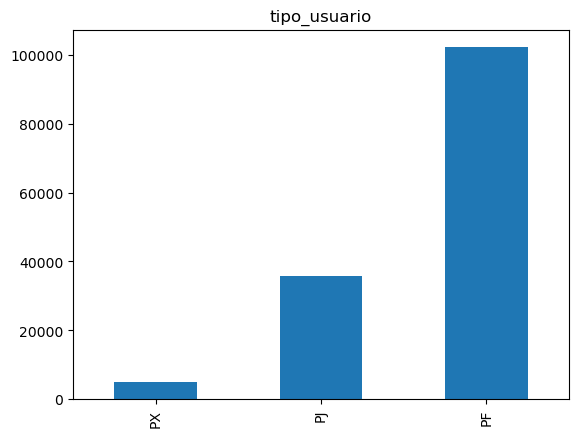

In [239]:
print('valores_unicos: \n',df_agg_final["tipo_usuario"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["tipo_usuario"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["tipo_usuario"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["tipo_usuario"].isna().sum(),'\n')

df_agg_final['tipo_usuario'].value_counts().sort_values().plot(kind = 'bar')
plt.title('tipo_usuario')

### canal_registro

In [240]:
print('valores_unicos: \n',df_agg_final["canal_registro"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["canal_registro"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["canal_registro"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["canal_registro"].isna().sum(),'\n')

valores_unicos: 
 [ 3.  2.  4.  8.  7.  1.  6.  9. nan] 

total_valores_unicos:  8 

tabla_valores_unicos: 

 3.0    38225
1.0    29196
2.0    23976
7.0    13579
4.0    13546
8.0    13545
6.0     4745
9.0     2403
Name: canal_registro, dtype: int64 

total_valores_null:  3521 



In [241]:
df_agg_final['canal_registro'].loc[df_agg_final['canal_registro'] == 1.] = "SEM"
df_agg_final['canal_registro'].loc[df_agg_final['canal_registro'] == 4.] = "SEO"
df_agg_final['canal_registro'].loc[df_agg_final['canal_registro'].isin([2.,3.,7.])] = "directorios_populares"
df_agg_final['canal_registro'].loc[df_agg_final['canal_registro'].isin([6.,8.,9.])] = "directorios_especializados"
df_agg_final['canal_registro'].fillna("otros_canales", inplace=True)

C:\Users\mirei\AppData\Local\Temp\ipykernel_26416\2862994152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg_final['canal_registro'].loc[df_agg_final['canal_registro'] == 1.] = "SEM"


Text(0.5, 1.0, 'canal_registro')

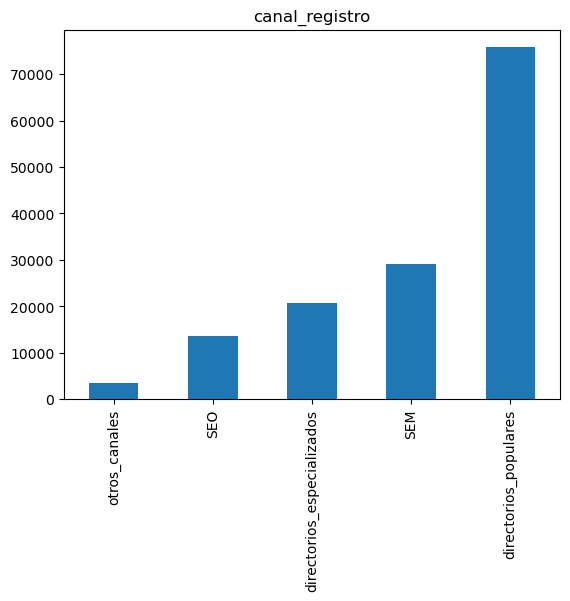

In [242]:
#display(df_agg_final['canal_registro'].value_counts())
df_agg_final['canal_registro'].value_counts().sort_values().plot(kind = 'bar')
plt.title('canal_registro')

### tipo_email

In [243]:
print('valores_unicos: \n',df_agg_final["tipo_email"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["tipo_email"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["tipo_email"].value_counts().head(10),'\n')
print('total_valores_null: ',df_agg_final["tipo_email"].isna().sum(),'\n')

valores_unicos: 
 ['gmail.com' 'hotmail.com' 'ilc.com.co' ... 'litigamos.com'
 'peraltaperfileria.com' 'tobiasemanuel.org'] 

total_valores_unicos:  12788 

tabla_valores_unicos: 

 gmail.com        58809
hotmail.com      44861
yopmail.com       2921
yahoo.com         2769
yahoo.es          2124
outlook.com       1783
hotmail.es        1472
cool.fr.nf         925
misena.edu.co      854
outlook.es         598
Name: tipo_email, dtype: int64 

total_valores_null:  0 



### bondad_email

In [244]:
print('valores_unicos: \n',df_agg_final["bondad_email"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["bondad_email"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["bondad_email"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["bondad_email"].isna().sum(),'\n')

valores_unicos: 
 [ 20   0 -10   9   1 -20] 

total_valores_unicos:  6 

tabla_valores_unicos: 

  20    99024
 0     26499
-10     9458
-20     3893
 9      1996
 1      1866
Name: bondad_email, dtype: int64 

total_valores_null:  0 



In [245]:
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == 20] = "email_OK"
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == 9] = "email_naranja"
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == 1] = "SPAM"
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == 0] = "email_rojo"
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == -10] = "email_sin_dominio"
df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == -20] = "no_email"

C:\Users\mirei\AppData\Local\Temp\ipykernel_26416\1037297617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg_final['bondad_email'].loc[df_agg_final['bondad_email'] == 20] = "email_OK"


Text(0.5, 1.0, 'bondad_email')

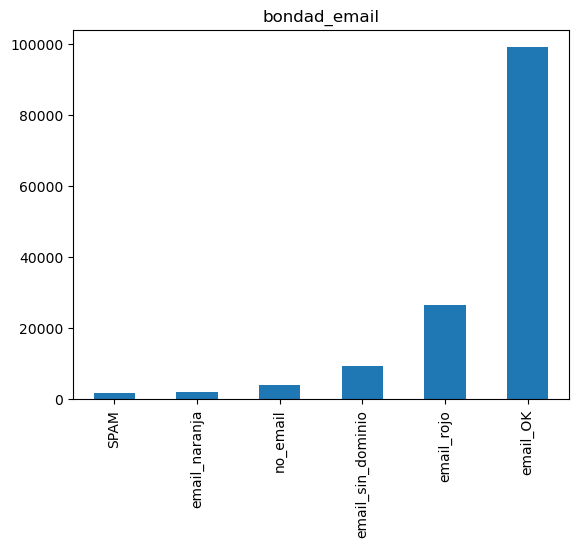

In [246]:
#display(df_agg_final['canal_registro'].value_counts())
df_agg_final['bondad_email'].value_counts().sort_values().plot(kind = 'bar')
plt.title('bondad_email')

### usuario_tipo

In [67]:
print('valores_unicos: \n',df_agg_final["usuario_tipo"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["usuario_tipo"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["usuario_tipo"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["usuario_tipo"].isna().sum(),'\n')

valores_unicos: 
 [nan 'EMPRESARIO INDIVIDUAL' 'SOCIEDAD COMERCIAL/INDUSTRIAL'
 'ENTIDAD FINANCIERA O DE SEGUROS' 'ENTIDAD SIN ANIMO DE LUCRO'
 'ORGANISMO ESTATAL' 'HOLDING' 'SOCIEDAD NO COMERCIAL'
 'ENTIDAD EXTRANJERA' 'INDUSTRIA / COMERCIO'] 

total_valores_unicos:  9 

tabla_valores_unicos: 

 SOCIEDAD COMERCIAL/INDUSTRIAL      16021
EMPRESARIO INDIVIDUAL              14635
ENTIDAD FINANCIERA O DE SEGUROS     1063
ENTIDAD SIN ANIMO DE LUCRO          1011
ORGANISMO ESTATAL                    262
HOLDING                              177
ENTIDAD EXTRANJERA                   132
SOCIEDAD NO COMERCIAL                  5
INDUSTRIA / COMERCIO                   2
Name: usuario_tipo, dtype: int64 

total_valores_null:  109428 



In [68]:
df_agg_final['usuario_tipo'].fillna("OTROS_TIPOS", inplace=True)

Text(0.5, 1.0, 'usuario_tipo')

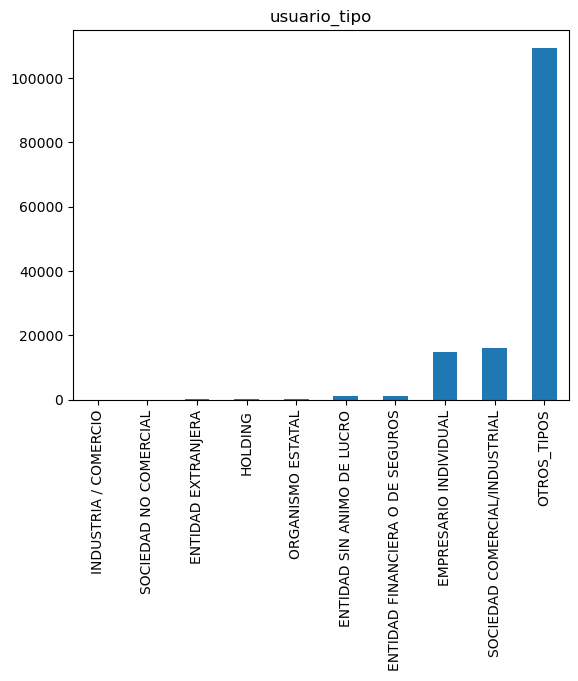

In [69]:
df_agg_final['usuario_tipo'].value_counts().sort_values().plot(kind = 'bar')
plt.title('usuario_tipo')

### usuario_tamano_comp

In [70]:
print('valores_unicos: \n',df_agg_final["usuario_tamano_comp"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["usuario_tamano_comp"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["usuario_tamano_comp"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["usuario_tamano_comp"].isna().sum(),'\n')

valores_unicos: 
 [nan 'MC' 'PQ' 'MD' 'SD' 'GR'] 

total_valores_unicos:  5 

tabla_valores_unicos: 

 MC    23096
PQ     4387
MD     2612
GR     2524
SD      690
Name: usuario_tamano_comp, dtype: int64 

total_valores_null:  109427 



In [71]:
df_agg_final['usuario_tamano_comp'].fillna("NSNC", inplace=True)

Text(0.5, 1.0, 'usuario_tamano_comp')

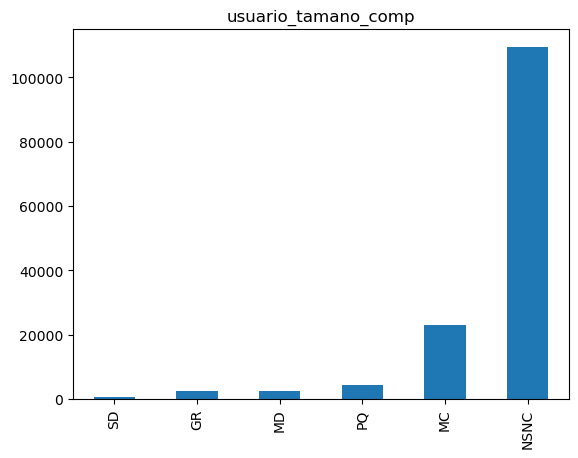

In [72]:
df_agg_final['usuario_tamano_comp'].value_counts().sort_values().plot(kind = 'bar')
plt.title('usuario_tamano_comp')

### usuario_ciiu

In [73]:
#print('valores_unicos: \n',df_agg_final["usuario_ciiu"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["usuario_ciiu"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["usuario_ciiu"].value_counts().head(),'\n')
print('total_valores_null: ',df_agg_final["usuario_ciiu"].isna().sum(),'\n')

total_valores_unicos:  546 

tabla_valores_unicos: 

 G4711    927
M7110    808
M7020    789
I5611    706
N8299    685
Name: usuario_ciiu, dtype: int64 

total_valores_null:  109427 



Text(0.5, 1.0, 'usuario_ciiu')

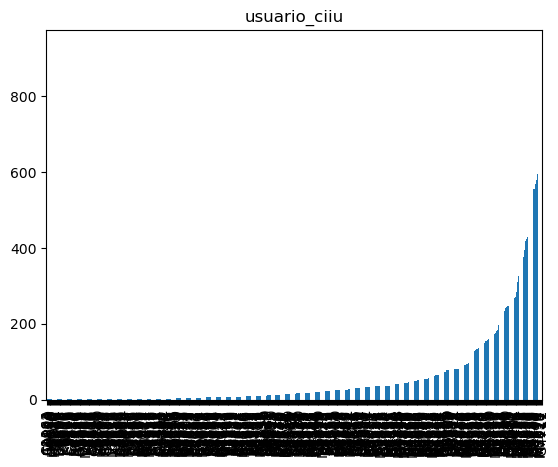

In [247]:
df_agg_final['usuario_ciiu'].value_counts().sort_values().plot(kind = 'bar')
plt.title('usuario_ciiu')

### usuario_estado

In [74]:
print('valores_unicos: \n',df_agg_final["usuario_estado"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["usuario_estado"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["usuario_estado"].value_counts(),'\n')
print('total_valores_null: ',df_agg_final["usuario_estado"].isna().sum(),'\n')

valores_unicos: 
 [nan 'ACTIVA' 'CANCELACIÓN' 'LIQUIDACION'
 'LEY DE INSOLVENCIA (REORGANIZACION EMPRESARIAL)' 'EXTINGUIDA'
 'INACTIVA TEMPORAL' 'REESTRUCTURACION O CONCORDATO'
 'COINCIDENCIA HOMOGRAFA LISTA CLINTON (SDNT OFAC)' 'INTERVENIDA'
 'ANULACIÓN LIQUIDACIÓN' 'SALIDA CLINTON (SDNT OFAC)'] 

total_valores_unicos:  11 

tabla_valores_unicos: 

 ACTIVA                                              26726
CANCELACIÓN                                          5109
LIQUIDACION                                          1004
LEY DE INSOLVENCIA (REORGANIZACION EMPRESARIAL)       236
EXTINGUIDA                                            114
INACTIVA TEMPORAL                                      97
REESTRUCTURACION O CONCORDATO                           9
COINCIDENCIA HOMOGRAFA LISTA CLINTON (SDNT OFAC)        5
SALIDA CLINTON (SDNT OFAC)                              4
INTERVENIDA                                             3
ANULACIÓN LIQUIDACIÓN                                   2
Name: usu

In [75]:
df_agg_final['usuario_estado'].fillna("DESCONOCIDO", inplace=True)

Text(0.5, 1.0, 'usuario_estado')

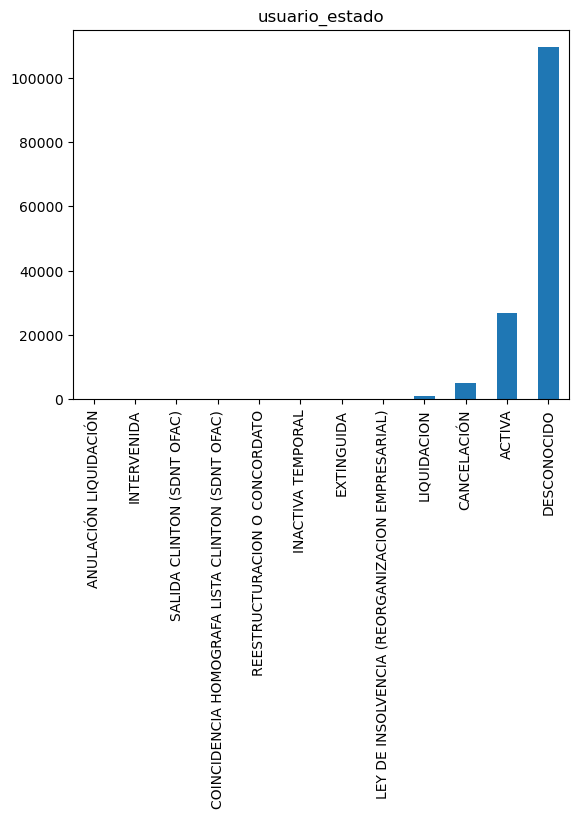

In [76]:
df_agg_final['usuario_estado'].value_counts().sort_values().plot(kind = 'bar')
plt.title('usuario_estado')

### usuario_departamento

In [77]:
print('valores_unicos: \n',df_agg_final["usuario_departamento"].unique(),'\n')
print('total_valores_unicos: ',df_agg_final["usuario_departamento"].nunique(),'\n')
print('tabla_valores_unicos: \n\n', df_agg_final["usuario_departamento"].value_counts().head(),'\n')
print('total_valores_null: ',df_agg_final["usuario_departamento"].isna().sum(),'\n')

valores_unicos: 
 [nan 'CALDAS' 'BOGOTA' 'CAQUETA' 'TOLIMA' 'MAGDALENA' 'CUNDINAMARCA'
 'ANTIOQUIA' 'HUILA' 'CESAR' 'META' 'SANTANDER' 'NORTE SANTANDER' 'SUCRE'
 'ATLANTICO' 'VALLE' 'RISARALDA' 'CAUCA' 'BOLIVAR' 'NARINO' 'QUINDIO'
 'BOYACA' 'LA GUAJIRA' 'ARAUCA' 'CORDOBA' 'CASANARE' 'PUTUMAYO' 'GUAVIARE'
 'CHOCO' 'SAN ANDRES' 'AMAZONAS' 'VAUPES' 'GUAINIA'] 

total_valores_unicos:  32 

tabla_valores_unicos: 

 BOGOTA          14168
ANTIOQUIA        4366
VALLE            2898
CUNDINAMARCA     1941
ATLANTICO        1665
Name: usuario_departamento, dtype: int64 

total_valores_null:  106789 



Text(0.5, 1.0, 'usuario_departamento')

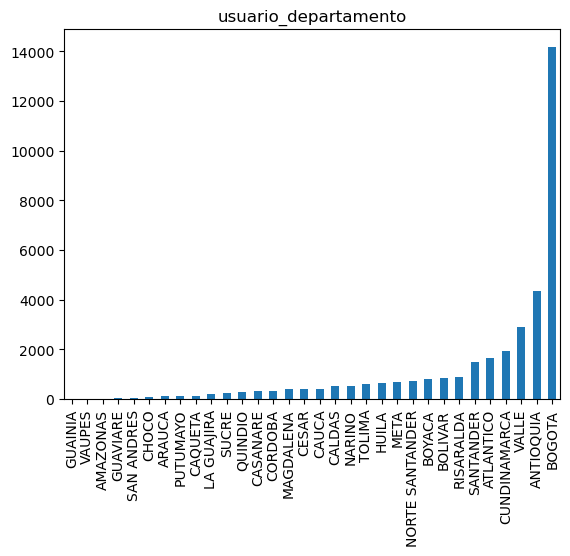

In [78]:
df_agg_final['usuario_departamento'].value_counts().sort_values().plot(kind = 'bar')
plt.title('usuario_departamento')

## otras variables 

### fecha_cliente

total_valores_unicos:  810 

total_valores_null:  140127 



(array([316., 390., 374., 377., 408., 420., 120.,  86.,  96.,  22.]),
 array([17533. , 17651.5, 17770. , 17888.5, 18007. , 18125.5, 18244. ,
        18362.5, 18481. , 18599.5, 18718. ]),
 <BarContainer object of 10 artists>)

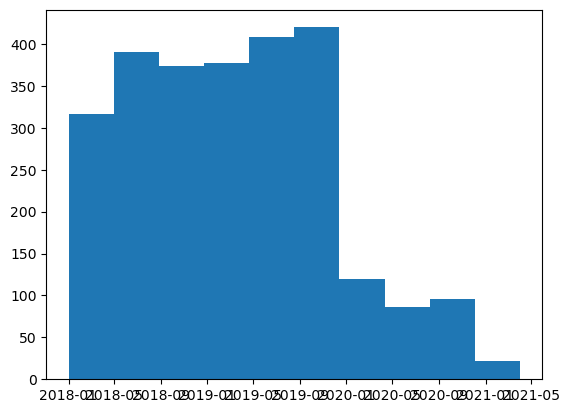

In [79]:
print('total_valores_unicos: ',df_agg_final["fecha_cliente"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["fecha_cliente"].isna().sum(),'\n')

plt.hist(df_agg_final["fecha_cliente"])

### consumos_count *

In [80]:
df_agg_final['consumos_count'].fillna(0, inplace=True)


print('total_valores_unicos: ',df_agg_final["consumos_count"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["consumos_count"].isna().sum(),'\n')
print('min: ',df_agg_final["consumos_count"].min(),'\n')
print('max: ',df_agg_final["consumos_count"].max(),'\n')

#plt.hist(df_agg_final["consumos_count"],bins = 50)

total_valores_unicos:  153 

total_valores_null:  0 

min:  0.0 

max:  3207.0 



### total_productos

total_valores_unicos:  152 

total_valores_null:  27 

min:  1.0 

max:  3207.0 



(array([1.4273e+05, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0. ,  641.4, 1282.8, 1924.2, 2565.6, 3207. ]),
 <BarContainer object of 5 artists>)

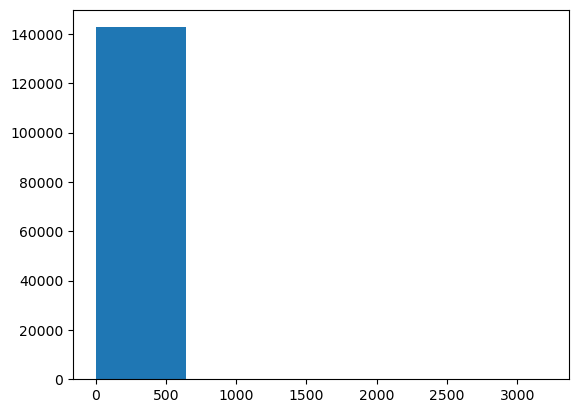

In [81]:
print('total_valores_unicos: ',df_agg_final["total_productos"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["total_productos"].isna().sum(),'\n')
print('min: ',df_agg_final["total_productos"].min(),'\n')
print('max: ',df_agg_final["total_productos"].max(),'\n')

df_agg_final['total_productos'].fillna(0, inplace=True)

plt.hist(df_agg_final["total_productos"], bins = 5)

In [82]:
df_agg_final.query('total_productos>=3000')


,id_usuario,tipo_usuario,fecha_registro,canal_registro,indicador_cliente,tipo_email,bondad_email,usuario_tipo,usuario_tamano_comp,usuario_ciiu,...,productos_distintos,empresas_totales_consultadas_usuario,empresas_unicas_consultadas_usuario,perfil_promocional,ficha_basica,dias_entre_consumos,total_sesiones,dias_sesiones,media_sesiones_dia,dias_entre_sesiones
142735,7943229,PF,2019-07-08,SEM,0,hotmail.com,SPAM,OTROS_TIPOS,NSNC,NaN,...,2.0,3207.0,3141.0,1.0,1.0,275.0,6346,42,151.095238,275


### productos_distintos

total_valores_unicos:  2 

total_valores_null:  27 

min:  1.0 

max:  2.0 



<Axes: >

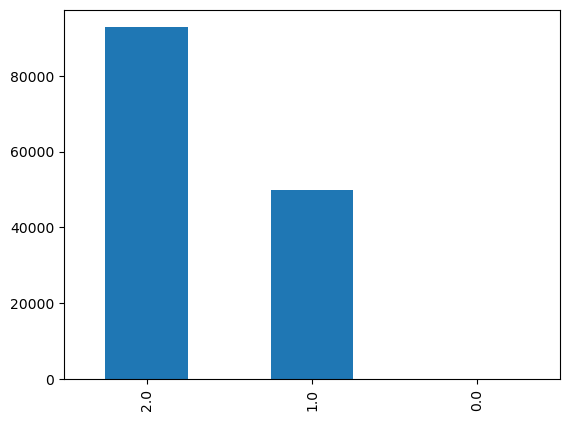

In [83]:
print('total_valores_unicos: ',df_agg_final["productos_distintos"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["productos_distintos"].isna().sum(),'\n')
print('min: ',df_agg_final["productos_distintos"].min(),'\n')
print('max: ',df_agg_final["productos_distintos"].max(),'\n')


df_agg_final['productos_distintos'].fillna(0, inplace=True)

df_agg_final["productos_distintos"].value_counts().plot(kind='bar')

### empresas_totales_consultadas_usuario

In [84]:
print('total_valores_unicos: ',df_agg_final["empresas_totales_consultadas_usuario"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["empresas_totales_consultadas_usuario"].isna().sum(),'\n')
print('min: ',df_agg_final["empresas_totales_consultadas_usuario"].min(),'\n')
print('max: ',df_agg_final["empresas_totales_consultadas_usuario"].max(),'\n')

#df_agg_final["empresas_totales_consultadas_usuario"].value_counts().plot(kind='bar')
#plt.hist(df_agg_final["empresas_totales_consultadas_usuario"])

total_valores_unicos:  152 

total_valores_null:  27 

min:  1.0 

max:  3207.0 



### empresas_unicas_consultadas_usuario

In [85]:
print('total_valores_unicos: ',df_agg_final["empresas_unicas_consultadas_usuario"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["empresas_unicas_consultadas_usuario"].isna().sum(),'\n')
print('min: ',df_agg_final["empresas_unicas_consultadas_usuario"].min(),'\n')
print('max: ',df_agg_final["empresas_unicas_consultadas_usuario"].max(),'\n')

#df_agg_final["empresas_unicas_consultadas_usuario"].value_counts().plot(kind='bar')
#plt.hist(df_agg_final["empresas_unicas_consultadas_usuario"])

total_valores_unicos:  140 

total_valores_null:  27 

min:  1.0 

max:  3141.0 



### perfil_promocional

total_valores_unicos:  2 

total_valores_null:  27 

min:  0.0 

max:  1.0 



<Axes: >

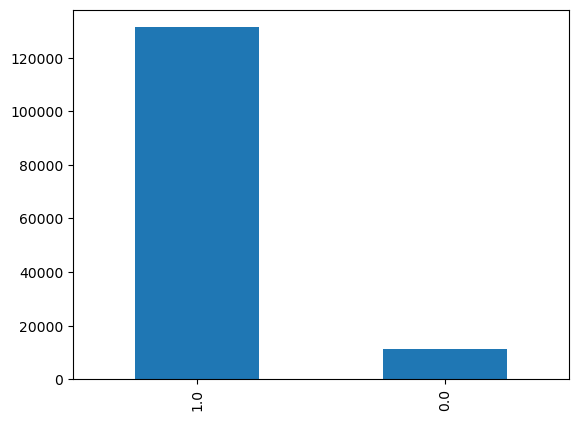

In [86]:
print('total_valores_unicos: ',df_agg_final["perfil_promocional"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["perfil_promocional"].isna().sum(),'\n')
print('min: ',df_agg_final["perfil_promocional"].min(),'\n')
print('max: ',df_agg_final["perfil_promocional"].max(),'\n')

df_agg_final['perfil_promocional'].fillna(0, inplace=True)

df_agg_final["perfil_promocional"].value_counts().plot(kind='bar')

### ficha_basica

total_valores_unicos:  2 

total_valores_null:  27 

min:  0.0 

max:  1.0 



<Axes: >

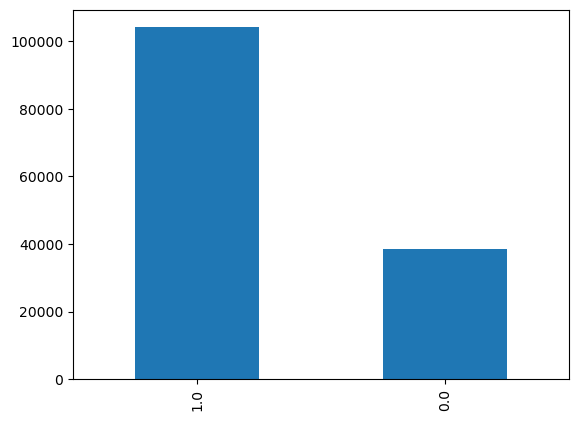

In [87]:
print('total_valores_unicos: ',df_agg_final["ficha_basica"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["ficha_basica"].isna().sum(),'\n')
print('min: ',df_agg_final["ficha_basica"].min(),'\n')
print('max: ',df_agg_final["ficha_basica"].max(),'\n')


df_agg_final['ficha_basica'].fillna(0, inplace=True)

df_agg_final["ficha_basica"].value_counts().plot(kind='bar')

### dias_entre_consumos *

total_valores_unicos:  1005 

total_valores_null:  27 

min:  0.0 

max:  1374.0 



(array([1.32945e+05, 4.54100e+03, 2.48700e+03, 1.32600e+03, 7.27000e+02,
        3.58000e+02, 2.44000e+02, 9.90000e+01, 4.00000e+00, 5.00000e+00]),
 array([   0. ,  137.4,  274.8,  412.2,  549.6,  687. ,  824.4,  961.8,
        1099.2, 1236.6, 1374. ]),
 <BarContainer object of 10 artists>)

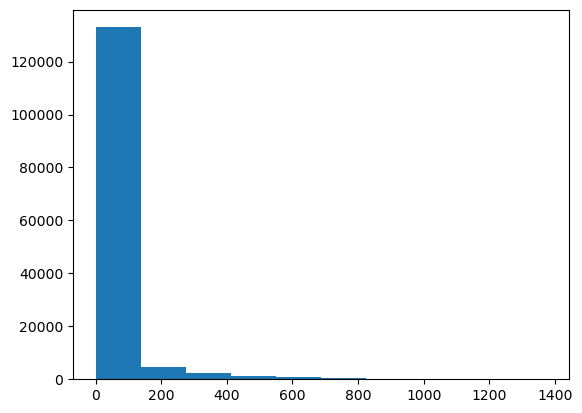

In [88]:
print('total_valores_unicos: ',df_agg_final["dias_entre_consumos"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["dias_entre_consumos"].isna().sum(),'\n')
print('min: ',df_agg_final["dias_entre_consumos"].min(),'\n')
print('max: ',df_agg_final["dias_entre_consumos"].max(),'\n')

df_agg_final['dias_entre_consumos'].fillna(0, inplace=True)

#df_agg_final["dias_entre_consumos"].value_counts().plot(kind='bar')
plt.hist(df_agg_final["dias_entre_consumos"])

### total_sesiones

In [89]:
print('total_valores_unicos: ',df_agg_final["total_sesiones"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["total_sesiones"].isna().sum(),'\n')
print('min: ',df_agg_final["total_sesiones"].min(),'\n')
print('max: ',df_agg_final["total_sesiones"].max(),'\n')

#df_agg_final["total_sesiones"].value_counts().plot(kind='bar')
#plt.hist(df_agg_final["total_sesiones"])

total_valores_unicos:  223 

total_valores_null:  0 

min:  4 

max:  6346 



### dias_sesiones

In [90]:
print('total_valores_unicos: ',df_agg_final["dias_sesiones"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["dias_sesiones"].isna().sum(),'\n')
print('min: ',df_agg_final["dias_sesiones"].min(),'\n')
print('max: ',df_agg_final["dias_sesiones"].max(),'\n')

#df_agg_final["dias_sesiones"].value_counts().plot(kind='bar')
#plt.hist(df_agg_final["dias_sesiones"])

total_valores_unicos:  41 

total_valores_null:  0 

min:  1 

max:  129 



### media_sesiones_dia

In [91]:
print('total_valores_unicos: ',df_agg_final["media_sesiones_dia"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["media_sesiones_dia"].isna().sum(),'\n')
print('min: ',df_agg_final["media_sesiones_dia"].min(),'\n')
print('max: ',df_agg_final["media_sesiones_dia"].max(),'\n')

#df_agg_final["media_sesiones_dia"].value_counts().plot(kind='bar')
#plt.hist(df_agg_final["media_sesiones_dia"])

total_valores_unicos:  478 

total_valores_null:  0 

min:  1.0 

max:  552.0 



### dias_entre_sesiones

total_valores_unicos:  1288 

total_valores_null:  0 

min:  0 

max:  1606 



(array([1.30316e+05, 5.75400e+03, 2.86200e+03, 1.48500e+03, 1.00500e+03,
        6.15000e+02, 4.01000e+02, 2.17000e+02, 7.80000e+01, 3.00000e+00]),
 array([   0. ,  160.6,  321.2,  481.8,  642.4,  803. ,  963.6, 1124.2,
        1284.8, 1445.4, 1606. ]),
 <BarContainer object of 10 artists>)

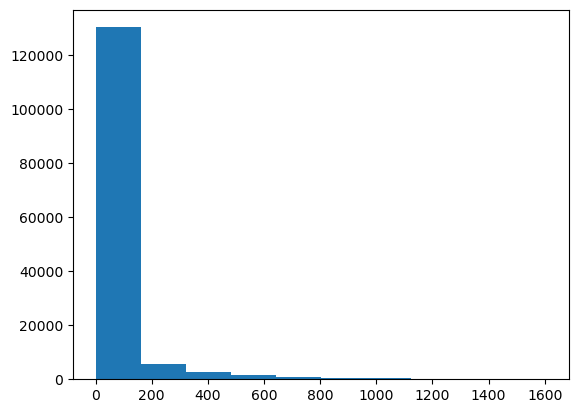

In [92]:
print('total_valores_unicos: ',df_agg_final["dias_entre_sesiones"].nunique(),'\n')
print('total_valores_null: ',df_agg_final["dias_entre_sesiones"].isna().sum(),'\n')
print('min: ',df_agg_final["dias_entre_sesiones"].min(),'\n')
print('max: ',df_agg_final["dias_entre_sesiones"].max(),'\n')

#df_agg_final["dias_entre_sesiones"].value_counts().plot(kind='bar')
plt.hist(df_agg_final["dias_entre_sesiones"])

# TABLA FINAL (limpieza de campos)

In [93]:
df_agg_final.shape

(142736, 25)

df_agg_final.isna().sum()

In [94]:
df_agg_final_clean = df_agg_final.drop(['id_usuario','fecha_registro','fecha_cliente'
                                       ,'tipo_email'
                                       , 'usuario_tipo','usuario_tamano_comp','usuario_ciiu','usuario_estado','usuario_departamento' 
                                       ,'empresas_totales_consultadas_usuario','empresas_unicas_consultadas_usuario'
                                       #,'empresas_totales_consultadas_usuario','empresas_unicas_consultadas_usuario','perfil_promocional','ficha_basica'
                                       #,'consumos_count','dias_entre_consumos'
                                       ], axis = 1)

In [95]:
df_agg_final_clean.shape

(142736, 14)

In [96]:
df_agg_final_clean.isna().sum()

tipo_usuario           0
canal_registro         0
indicador_cliente      0
bondad_email           0
consumos_count         0
total_productos        0
productos_distintos    0
perfil_promocional     0
ficha_basica           0
dias_entre_consumos    0
total_sesiones         0
dias_sesiones          0
media_sesiones_dia     0
dias_entre_sesiones    0
dtype: int64

# PARTE 2

## test phi 2

In [97]:
def test_chi2(dataset, variable_objetivo, alpha = 0.05):
    
    X = dataset.select_dtypes('object')
    y = dataset[variable_objetivo]

    chi2 = []
    p_value = []
    chi2_check = []
    for i in X.columns:
        chi_res = chi2_contingency(pd.crosstab(y, X[i]))
        chi2.append(round(chi_res[0],4))
        p_value.append(chi_res[1])
        #print('p-valor', p_value[-1])
        if chi_res[1] < alpha:
            chi2_check.append('Se rechaza la hipótesis nula')
        else:
            chi2_check.append('No se rechaza la hipótesis nula')
      
    res = pd.DataFrame(data = [X.columns, chi2, p_value, chi2_check]).T 
      
    res.columns = ['Columna', 'Chi2','p-valor', 'Hipótesis']

  
    return res

## correlación

In [98]:
def confusion_matrix_result(df):
  cm= df.corr()
  #cor_mat= df_numericas[:].corr()
  fig, ax = plt.subplots(figsize=(10,8))
  sns.heatmap(cm,  annot=True, cmap='Greens', ax = ax)
  return 

## anova

In [99]:
def test_anova(dataset, variable_objetivo, alpha = 0.05):
    
    X = dataset.select_dtypes(exclude=['object']).drop([variable_objetivo], axis = 1)
    y = dataset[variable_objetivo]

    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X, y)
    
    anova_check = []
    for i in range(len(fs.scores_)):
        if fs.pvalues_[i] < alpha:
            anova_check.append('Se rechaza la hipótesis nula')
        else:
            anova_check.append('No se rechaza la hipótesis nula')
      
    res = pd.DataFrame(data = [X.columns, fs.scores_, fs.pvalues_, anova_check]).T 
    res.columns = ['Columna', 'fvalor','p-valor', 'Hipótesis']
    
    return res

In [100]:
test_chi2(df_agg_final_clean,'indicador_cliente')

,Columna,Chi2,p-valor,Hipótesis
0,tipo_usuario,944.8761,0.0,Se rechaza la hipótesis nula
1,canal_registro,43.2781,0.0,Se rechaza la hipótesis nula
2,bondad_email,751.827,0.0,Se rechaza la hipótesis nula


C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\927377658.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm= df.corr()


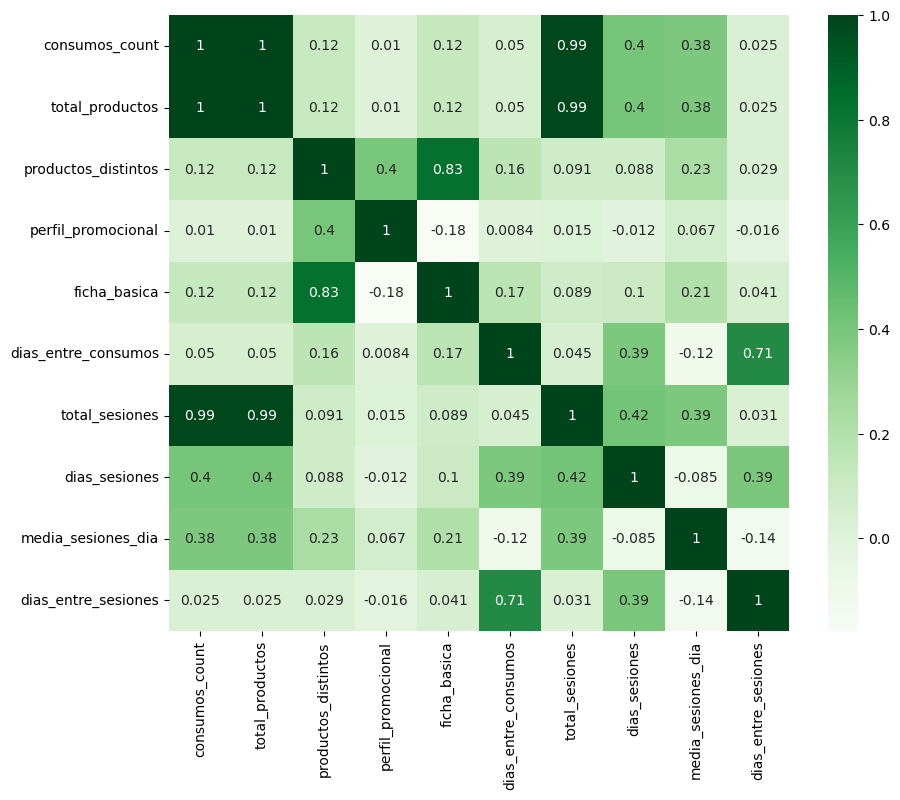

In [101]:
confusion_matrix_result(df_agg_final_clean.drop(['indicador_cliente'], axis = 1))

In [102]:
test_anova(df_agg_final_clean, 'indicador_cliente')

,Columna,fvalor,p-valor,Hipótesis
0,consumos_count,17.255979,0.000033,Se rechaza la hipótesis nula
1,total_productos,17.255979,0.000033,Se rechaza la hipótesis nula
2,productos_distintos,19.308465,0.000011,Se rechaza la hipótesis nula
3,perfil_promocional,768.415089,0.0,Se rechaza la hipótesis nula
4,ficha_basica,146.928896,0.0,Se rechaza la hipótesis nula
5,dias_entre_consumos,524.307734,0.0,Se rechaza la hipótesis nula
6,total_sesiones,215.675597,0.0,Se rechaza la hipótesis nula
7,dias_sesiones,452.623667,0.0,Se rechaza la hipótesis nula
8,media_sesiones_dia,658.856458,0.0,Se rechaza la hipótesis nula
9,dias_entre_sesiones,456.509872,0.0,Se rechaza la hipótesis nula


## seleccion variables

In [103]:
#df_final = df_agg_final.drop(['tipo_email','consumos_count','empresas_totales_consultadas_usuario'
#                              ,'empresas_unicas_consultadas_usuario','total_sesiones','dias_entre_consumos'
#                              ,'ficha_basica','perfil_promocional'], axis = 1)

In [104]:
#df_final = df_agg_final[['tipo_usuario','canal_registro','bondad_email','perfil_promocional'
#                        ,'total_sesiones','indicador_cliente']]

In [105]:
df_final = df_agg_final_clean.drop(['consumos_count','total_sesiones', 'productos_distintos', 'dias_entre_consumos'], axis = 1)

C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\927377658.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm= df.corr()


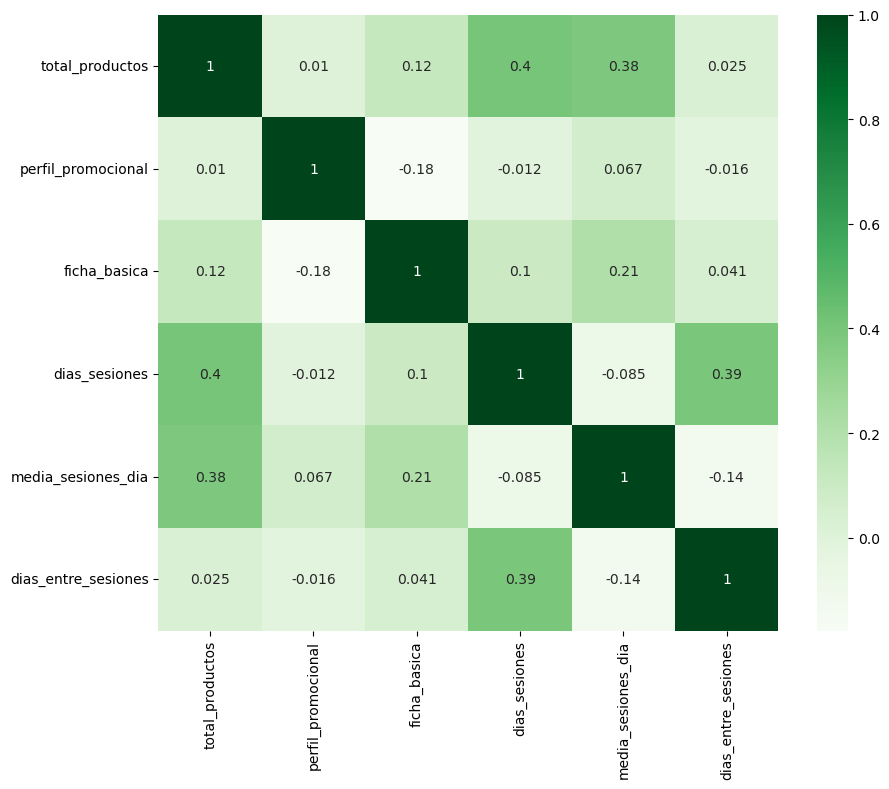

In [106]:
confusion_matrix_result(df_final.drop(['indicador_cliente'], axis = 1))

In [107]:
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 142736 entries, 0 to 142735
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   tipo_usuario         142736 non-null  object 
 1   canal_registro       142736 non-null  object 
 2   indicador_cliente    142736 non-null  int32  
 3   bondad_email         142736 non-null  object 
 4   total_productos      142736 non-null  float64
 5   perfil_promocional   142736 non-null  float64
 6   ficha_basica         142736 non-null  float64
 7   dias_sesiones        142736 non-null  int64  
 8   media_sesiones_dia   142736 non-null  float64
 9   dias_entre_sesiones  142736 non-null  int32  
dtypes: float64(4), int32(2), int64(1), object(3)
memory usage: 14.9+ MB


# TEST & TRAIN

In [108]:
def ohe(data):

    ohe = OneHotEncoder(sparse=False)
    data_ohencoded = pd.DataFrame(ohe.fit_transform(data.select_dtypes(object)))
    data_ohencoded.columns = np.unique(data.select_dtypes(object)).tolist()
  
    return pd.concat([data_ohencoded, data.reset_index(drop=True).drop(
        columns=data.select_dtypes(object).columns.tolist())], axis=1)

In [109]:
df_final_ohe = ohe(df_final)

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [110]:
X = df_final_ohe.drop(['indicador_cliente'],axis = 1)
y = df_final_ohe['indicador_cliente']

X_train, X_test_a, y_train, y_test_a = train_test_split(X, y, test_size=0.30, random_state=42)


X_test = X_test_a
y_test = y_test_a

#X = X_test_a
#y = y_test_a

#X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.50, random_state=42)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test' , X_test.shape)
print('y_test' , y_test.shape)
#print('X_val'  , X_val.shape)
#print('y_val'  , y_val.shape)

X_train (99915, 20)
y_train (99915,)
X_test (42821, 20)
y_test (42821,)


# tecnicas

link: https://pub.towardsai.net/imbalanced-learn-handling-imbalanced-class-problem-40aa3cb6525b

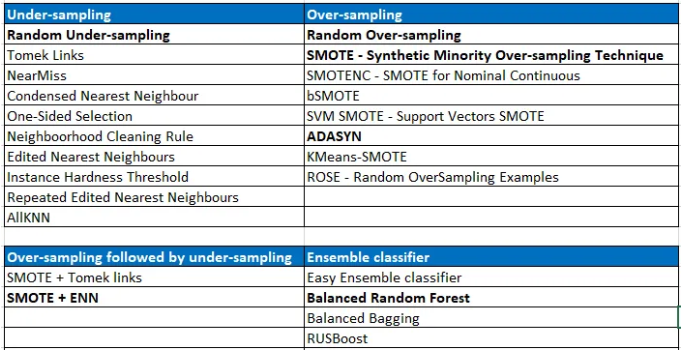


## under-sampling

https://imbalanced-learn.org/dev/references/under_sampling.html

In [111]:
# Random Under-Sampling
X_RUS, y_RUS = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_RUS))

Resampled dataset shape Counter({0: 1809, 1: 1809})


In [112]:
# MearMiss
X_NMS, y_NMS = NearMiss(n_neighbors = 3, version = 2).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_NMS))

Resampled dataset shape Counter({0: 1809, 1: 1809})


In [113]:
#start_time = timeit.default_timer()

# Condensed Nearest Neighbour
#X_CNN, y_CNN = CondensedNearestNeighbour(random_state=42).fit_resample(X_train, y_train)
#print('Resampled dataset shape %s' % Counter(y_CNN))

#elapsed = timeit.default_timer() - start_time
#print(elapsed)

In [114]:
# Edited Nearest Neighbour
X_ENN, y_ENN = EditedNearestNeighbours().fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_ENN))

Resampled dataset shape Counter({0: 96118, 1: 1809})


In [115]:
start_time = timeit.default_timer()

# Repeated Edited Neighbour
X_RNN, y_RNN = RepeatedEditedNearestNeighbours().fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_RNN))

elapsed = timeit.default_timer() - start_time
print(elapsed)

Resampled dataset shape Counter({0: 95700, 1: 1809})
32.22184649994597


In [116]:
# One-Sided Selection
X_OSS, y_OSS = OneSidedSelection(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_OSS))

Resampled dataset shape Counter({0: 97865, 1: 1809})


In [117]:
# Neighboorhood Cleaning Rule
X_NCR, y_NCR = NeighbourhoodCleaningRule().fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_NCR))

Resampled dataset shape Counter({0: 95061, 1: 1809})


In [118]:
# Instance Hardness Threshold
X_IHT, y_IHT =  InstanceHardnessThreshold(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_IHT))

Resampled dataset shape Counter({0: 68114, 1: 1809})


In [119]:
# AllKNN
X_allKNN, y_allKNN = AllKNN().fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_allKNN))

Resampled dataset shape Counter({0: 95768, 1: 1809})


In [120]:
# Tomek Links
X_TLS, y_TLS = TomekLinks().fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_TLS))

Resampled dataset shape Counter({0: 97834, 1: 1809})


<Axes: >

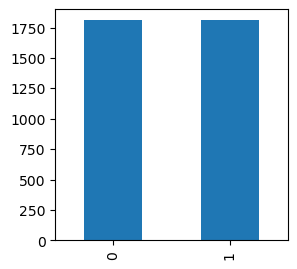

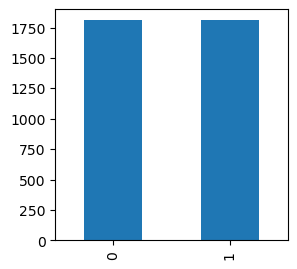

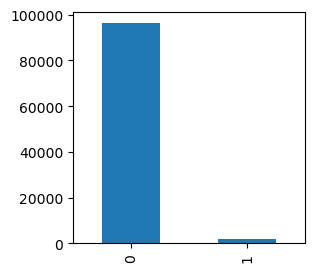

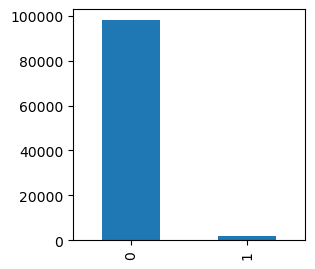

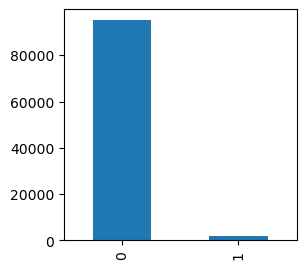

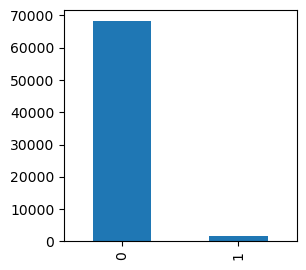

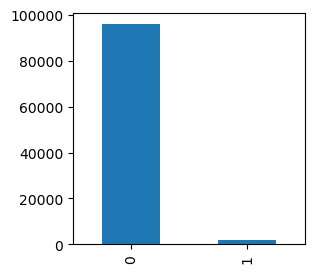

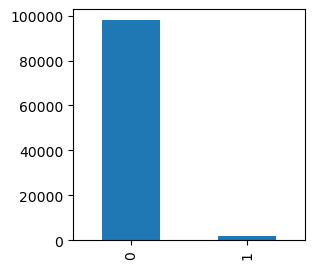

In [121]:
plt.figure(figsize=(3,3))
y_RUS.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_NMS.value_counts().plot(kind = 'bar')

#plt.figure(figsize=(3,3))
#y_CNN.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_ENN.value_counts().plot(kind = 'bar')

#plt.figure(figsize=(3,3))
#y_RNN.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_OSS.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_NCR.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_IHT.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_allKNN.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_TLS.value_counts().plot(kind = 'bar')

## Over-sampling

https://imbalanced-learn.org/dev/references/over_sampling.html

In [122]:
# Random Over-Sampling
X_ROS, y_ROS = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_ROS))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [123]:
X_ROS.shape
y_ROS.shape

(196212,)

In [124]:
# SMOTE
X_SMOTE, y_SMOTE = SMOTE(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_SMOTE))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [125]:
# SMOTENC
X_SMOTENC, y_SMOTENC = SMOTENC(random_state=42, categorical_features=[18, 19]).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_SMOTENC))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [126]:
# SMOTEN
X_SMOTEN, y_SMOTEN = SMOTEN(random_state=0).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_SMOTEN))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [127]:
# BorederlineSMOTE
X_BLSMOTE, y_BLSMOTE = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_BLSMOTE))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [128]:
# KMeansSMOTE
#X_KMSMOTE, y_KMSMOTE = KMeansSMOTE(
#    kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
#).fit_resample(X_train, y_train)
#print('Resampled dataset shape %s' % Counter(y_KMSMOTE))

In [129]:
# SVMSMOTE
X_SVMSMOTE, y_SVMSMOTE = SVMSMOTE(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_SVMSMOTE))

Resampled dataset shape Counter({0: 98106, 1: 98106})


In [130]:
# ADASYN
X_ADA, y_ADA = ADASYN(random_state=42).fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_ADA))

Resampled dataset shape Counter({1: 98605, 0: 98106})


<Axes: >

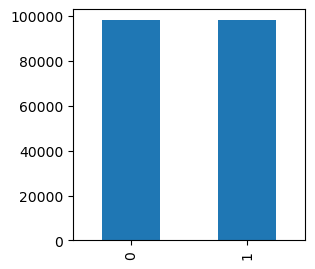

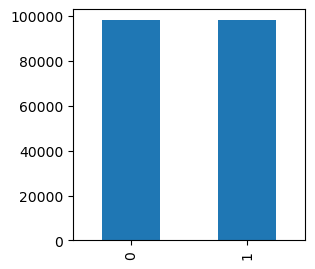

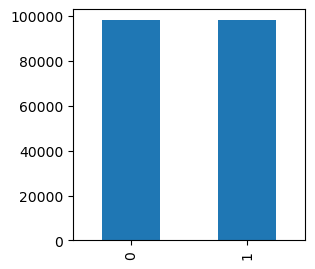

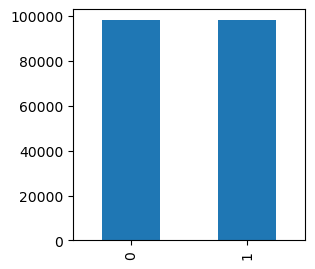

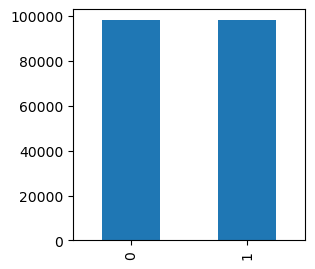

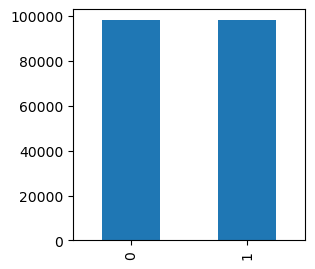

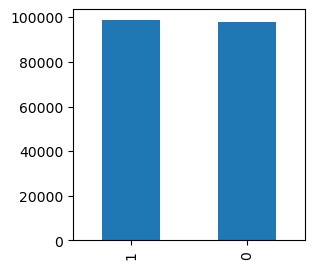

In [131]:
plt.figure(figsize=(3,3))
y_ROS.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_SMOTE.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_SMOTENC.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_SMOTEN.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_BLSMOTE.value_counts().plot(kind = 'bar')

#plt.figure(figsize=(3,3))
#y_KMSMOTE.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_SVMSMOTE.value_counts().plot(kind = 'bar')

plt.figure(figsize=(3,3))
y_ADA.value_counts().plot(kind = 'bar')

## Combination of over- and under-sampling methods

<Axes: >

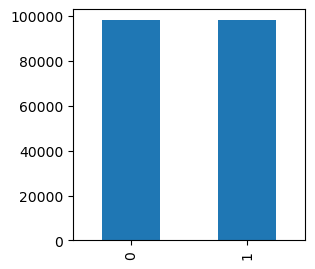

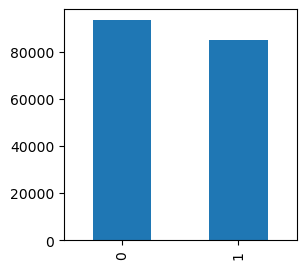

In [132]:
X_SMOTETomek, y_SMOTETomek = SMOTETomek().fit_resample(X_train, y_train)
X_SMOTEENN, y_SMOTEENN     = SMOTEENN().fit_resample(X_train, y_train)


plt.figure(figsize=(3,3))
y_SMOTETomek.value_counts().plot(kind = 'bar')
plt.figure(figsize=(3,3))
y_SMOTEENN.value_counts().plot(kind = 'bar')

# modelo evaluacion

## definiciones

In [133]:
def random_forest(xtrain, ytrain, xtest, ytest):
  clf = RandomForestClassifier(random_state = 100)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))



## under-sampling

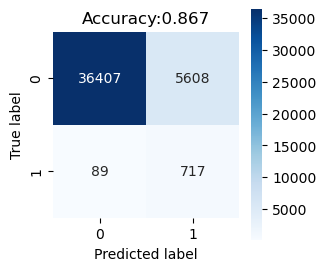

[0.86464088 0.87154696 0.8660221  0.86860304 0.88381743]

87.09 accuracy with a standard deviation of 0.69 

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     42015
           1       0.11      0.89      0.20       806

    accuracy                           0.87     42821
   macro avg       0.56      0.88      0.56     42821
weighted avg       0.98      0.87      0.91     42821



In [134]:
# Random Under-sampling (RUS)
random_forest(X_RUS, y_RUS, X_test, y_test)

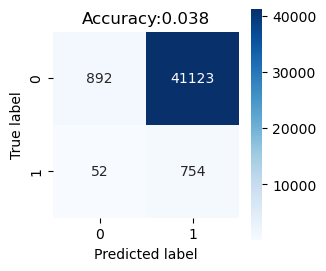

[0.95165746 0.95994475 0.95994475 0.94744122 0.71230982]

90.63 accuracy with a standard deviation of 9.71 

              precision    recall  f1-score   support

           0       0.94      0.02      0.04     42015
           1       0.02      0.94      0.04       806

    accuracy                           0.04     42821
   macro avg       0.48      0.48      0.04     42821
weighted avg       0.93      0.04      0.04     42821



In [135]:
# MearMiss
random_forest(X_NMS, y_NMS, X_test, y_test)

In [136]:
# Condensed Nearest Neighbour
#random_forest(X_CNN, y_CNN, X_test, y_test)

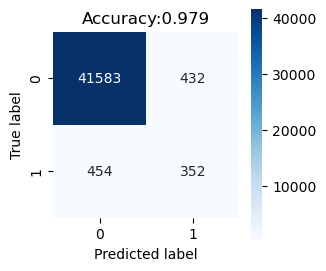

[0.9866231  0.98672521 0.98667347 0.98590758 0.98657136]

98.65 accuracy with a standard deviation of 0.03 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.45      0.44      0.44       806

    accuracy                           0.98     42821
   macro avg       0.72      0.71      0.72     42821
weighted avg       0.98      0.98      0.98     42821



In [137]:
# Edited Nearest Neighbour
random_forest(X_ENN, y_ENN, X_test, y_test)

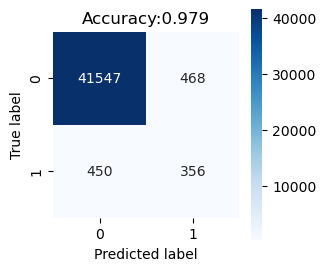

[0.98692442 0.98743719 0.98707825 0.98661676 0.98733398]

98.71 accuracy with a standard deviation of 0.03 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.43      0.44      0.44       806

    accuracy                           0.98     42821
   macro avg       0.71      0.72      0.71     42821
weighted avg       0.98      0.98      0.98     42821



In [138]:
# Repeated Edited Neighbour
random_forest(X_RNN, y_RNN, X_test, y_test)

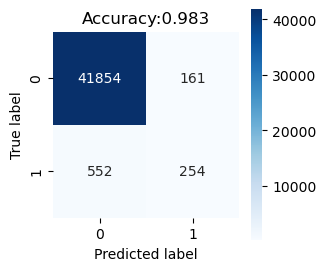

[0.98279408 0.98284424 0.98329571 0.9838475  0.9819404 ]

98.29 accuracy with a standard deviation of 0.06 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42015
           1       0.61      0.32      0.42       806

    accuracy                           0.98     42821
   macro avg       0.80      0.66      0.70     42821
weighted avg       0.98      0.98      0.98     42821



In [139]:
# One-Sided Selection
random_forest(X_OSS, y_OSS, X_test, y_test)

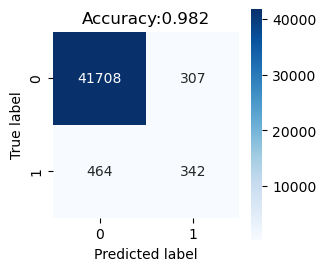

[0.98472179 0.98539279 0.98539279 0.98430887 0.98405079]

98.48 accuracy with a standard deviation of 0.05 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.53      0.42      0.47       806

    accuracy                           0.98     42821
   macro avg       0.76      0.71      0.73     42821
weighted avg       0.98      0.98      0.98     42821



In [140]:
# Neighboorhood Cleaning Rule
random_forest(X_NCR, y_NCR, X_test, y_test)

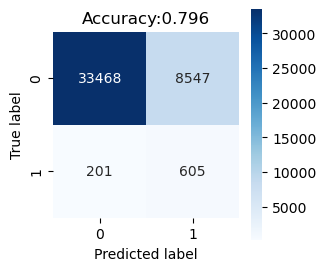

[0.99234895 0.99320701 0.99141938 0.99127574 0.99249142]

99.21 accuracy with a standard deviation of 0.07 

              precision    recall  f1-score   support

           0       0.99      0.80      0.88     42015
           1       0.07      0.75      0.12       806

    accuracy                           0.80     42821
   macro avg       0.53      0.77      0.50     42821
weighted avg       0.98      0.80      0.87     42821



In [141]:
# Instance Hardness Threshold
random_forest(X_IHT, y_IHT, X_test, y_test)

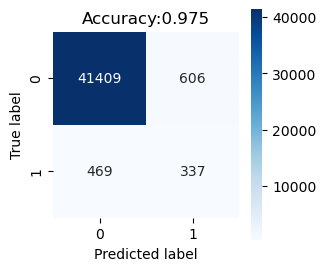

[0.98631892 0.9861652  0.98631822 0.98590828 0.98647194]

98.62 accuracy with a standard deviation of 0.02 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.36      0.42      0.39       806

    accuracy                           0.97     42821
   macro avg       0.67      0.70      0.69     42821
weighted avg       0.98      0.97      0.98     42821



In [142]:
# AllKNN
random_forest(X_allKNN, y_allKNN, X_test, y_test)

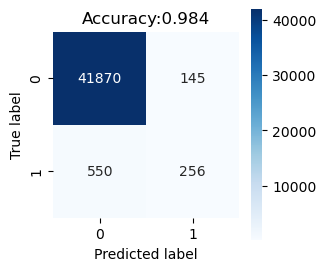

[0.98293943 0.98344122 0.98339104 0.98379165 0.98238659]

98.32 accuracy with a standard deviation of 0.05 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42015
           1       0.64      0.32      0.42       806

    accuracy                           0.98     42821
   macro avg       0.81      0.66      0.71     42821
weighted avg       0.98      0.98      0.98     42821



In [143]:
# Tomek Links
random_forest(X_TLS, y_TLS, X_test, y_test)

## over-sampling

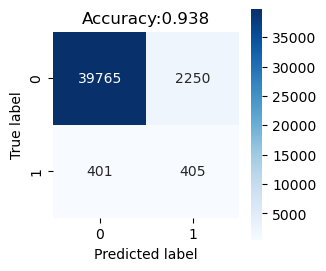

[0.96073185 0.96269398 0.96297334 0.96284593 0.96141889]

96.21 accuracy with a standard deviation of 0.09 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     42015
           1       0.15      0.50      0.23       806

    accuracy                           0.94     42821
   macro avg       0.57      0.72      0.60     42821
weighted avg       0.97      0.94      0.95     42821



In [144]:
# Random OVER-Sampling (ROS)
random_forest(X_ROS, y_ROS, X_test, y_test)

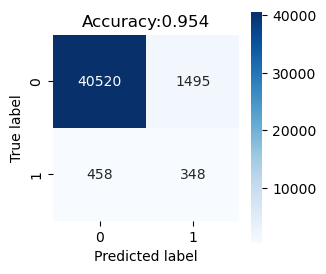

[0.95216981 0.97594475 0.97688701 0.97528159 0.97635187]

97.13 accuracy with a standard deviation of 0.96 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     42015
           1       0.19      0.43      0.26       806

    accuracy                           0.95     42821
   macro avg       0.59      0.70      0.62     42821
weighted avg       0.97      0.95      0.96     42821



In [145]:
# SMOTE
random_forest(X_SMOTE, y_SMOTE, X_test, y_test)

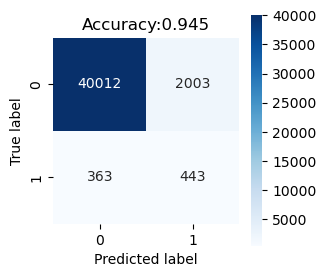

[0.9553551  0.96641439 0.96738189 0.96626064 0.96638805]

96.44 accuracy with a standard deviation of 0.45 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     42015
           1       0.18      0.55      0.27       806

    accuracy                           0.94     42821
   macro avg       0.59      0.75      0.62     42821
weighted avg       0.98      0.94      0.96     42821



In [146]:
# SMOTENC
random_forest(X_SMOTENC, y_SMOTENC, X_test, y_test)

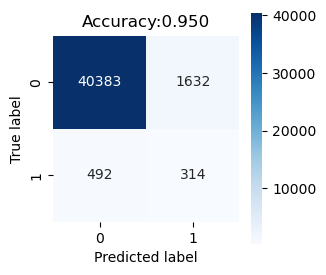

[0.94332747 0.97354942 0.97212171 0.97158657 0.97311554]

96.67 accuracy with a standard deviation of 1.17 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     42015
           1       0.16      0.39      0.23       806

    accuracy                           0.95     42821
   macro avg       0.57      0.68      0.60     42821
weighted avg       0.97      0.95      0.96     42821



In [147]:
# SMOTEN
random_forest(X_SMOTEN, y_SMOTEN, X_test, y_test)

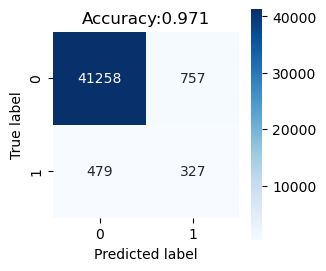

[0.96325459 0.98950131 0.99034198 0.98850721 0.9891188 ]

98.41 accuracy with a standard deviation of 1.05 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     42015
           1       0.30      0.41      0.35       806

    accuracy                           0.97     42821
   macro avg       0.65      0.69      0.67     42821
weighted avg       0.98      0.97      0.97     42821



In [148]:
# BorederlineSMOTE
random_forest(X_BLSMOTE, y_BLSMOTE, X_test, y_test)

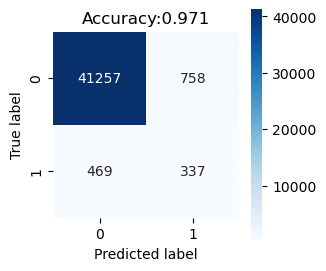

[0.95991642 0.98606121 0.98789562 0.98990877 0.99024005]

98.28 accuracy with a standard deviation of 1.15 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     42015
           1       0.31      0.42      0.35       806

    accuracy                           0.97     42821
   macro avg       0.65      0.70      0.67     42821
weighted avg       0.98      0.97      0.97     42821



In [149]:
# SVMSMOTE
random_forest(X_SVMSMOTE, y_SVMSMOTE, X_test, y_test)

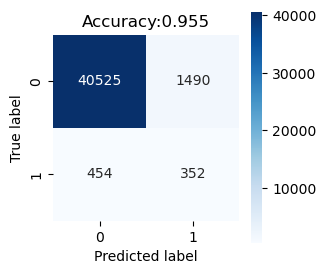

[0.93589711 0.95607747 0.96138986 0.96202532 0.96362666]

95.58 accuracy with a standard deviation of 1.03 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     42015
           1       0.19      0.44      0.27       806

    accuracy                           0.95     42821
   macro avg       0.59      0.70      0.62     42821
weighted avg       0.97      0.95      0.96     42821



In [150]:
# ADASYN
random_forest(X_ADA, y_ADA, X_test, y_test)

## Combination

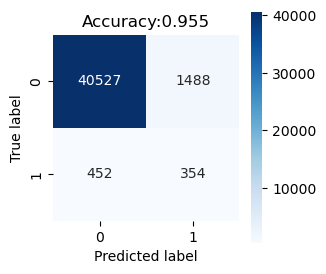

[0.95298677 0.97685032 0.97690131 0.97570303 0.97593187]

97.17 accuracy with a standard deviation of 0.94 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     42015
           1       0.19      0.44      0.27       806

    accuracy                           0.95     42821
   macro avg       0.59      0.70      0.62     42821
weighted avg       0.97      0.95      0.96     42821



In [151]:
# SMOTETomek
random_forest(X_SMOTETomek, y_SMOTETomek, X_test, y_test)

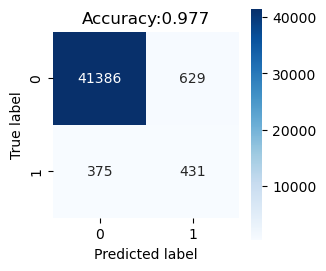

[0.98168221 0.99736717 0.99711501 0.997087   0.99705899]

99.41 accuracy with a standard deviation of 0.62 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.41      0.53      0.46       806

    accuracy                           0.98     42821
   macro avg       0.70      0.76      0.72     42821
weighted avg       0.98      0.98      0.98     42821



In [152]:
# SMOTEENN
random_forest(X_SMOTEENN, y_SMOTEENN, X_test, y_test)

# Resultados

In [175]:
def resultados_random_values(xtrain, ytrain, xtest, ytest,algoritmo):
  
  clf = RandomForestClassifier(random_state = 100)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)

  #print('\nf1_score_test',f1score_test)
  #print('\nrecall_test',recall_test)
  # accuracy_score, f1_score, recall_score, precision_score

  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  #return accuracy_test, recall_test, f1score_test
  return df_X

In [177]:
df_01 = resultados_random_values(X_RUS, y_RUS, X_test, y_test, 'RF_RUS_under')
df_02 = resultados_random_values(X_NMS, y_NMS, X_test, y_test, 'RF_NMS_under')
#df_03 = resultados_random_values(X_CNN, y_CNN, X_test, y_test, 'RF_CNN_under')
df_04 = resultados_random_values(X_ENN, y_ENN, X_test, y_test, 'RF_ENN_under')
df_05 = resultados_random_values(X_RNN, y_RNN, X_test, y_test, 'RF_RNN_under')
df_06 = resultados_random_values(X_OSS, y_OSS, X_test, y_test, 'RF_OSS_under')
df_07 = resultados_random_values(X_NCR, y_NCR, X_test, y_test, 'RF_NCR_under')
df_08 = resultados_random_values(X_IHT, y_IHT, X_test, y_test, 'RF_IHT_under')
df_09 = resultados_random_values(X_allKNN, y_allKNN, X_test, y_test, 'RF_allKNN_under')
df_10 = resultados_random_values(X_TLS, y_TLS, X_test, y_test, 'RF_TLS_under')
########################################################################################
df_11 = resultados_random_values(X_ROS, y_ROS, X_test, y_test, 'RF_ROS_over')
df_12 = resultados_random_values(X_SMOTE, y_SMOTE, X_test, y_test, 'RF_SMOTE_over')
df_13 = resultados_random_values(X_SMOTENC, y_SMOTENC, X_test, y_test, 'RF_SMOTENC_over')
df_14 = resultados_random_values(X_SMOTEN, y_SMOTEN, X_test, y_test, 'RF_SMOTEN_over')
df_15 = resultados_random_values(X_BLSMOTE, y_BLSMOTE, X_test, y_test, 'RF_BLSMOTE_over')
df_16 = resultados_random_values(X_SVMSMOTE, y_SVMSMOTE, X_test, y_test, 'RF_SVMSMOTE_over')
df_17 = resultados_random_values(X_ADA, y_ADA, X_test, y_test, 'RF_ADA_over')
########################################################################################
df_18 = resultados_random_values(X_SMOTETomek, y_SMOTETomek, X_test, y_test, 'RF_SMOTETomek_convine')
df_19 = resultados_random_values(X_SMOTEENN, y_SMOTEENN, X_test, y_test, 'RF_SMOTEENN_convine')

In [178]:
df_resultados_final = df_01.append(df_02) \
                           .append(df_04) \
                           .append(df_05) \
                           .append(df_06) \
                           .append(df_07) \
                           .append(df_08) \
                           .append(df_09) \
                           .append(df_10) \
                           .append(df_11) \
                           .append(df_12) \
                           .append(df_13) \
                           .append(df_14) \
                           .append(df_15) \
                           .append(df_16) \
                           .append(df_17) \
                           .append(df_18) \
                           .append(df_19) 


                           #.append(df_03) 

C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\4252919449.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados_final = df_01.append(df_02) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\4252919449.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_04) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\4252919449.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_05) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\4252919449.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_06) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\4252919449.py:5: FutureWarning: The frame.appen

In [179]:
df_resultados_final.T

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
algoritmo,RF_RUS_under,RF_NMS_under,RF_ENN_under,RF_RNN_under,RF_OSS_under,RF_NCR_under,RF_IHT_under,RF_allKNN_under,RF_TLS_under,RF_ROS_over,RF_SMOTE_over,RF_SMOTENC_over,RF_SMOTEN_over,RF_BLSMOTE_over,RF_SVMSMOTE_over,RF_ADA_over,RF_SMOTETomek_convine,RF_SMOTEENN_convine
accuracy,0.87,0.04,0.98,0.98,0.98,0.98,0.8,0.97,0.98,0.94,0.95,0.94,0.95,0.97,0.97,0.95,0.95,0.98
precision,0.11,0.02,0.45,0.43,0.61,0.53,0.07,0.36,0.64,0.15,0.19,0.18,0.16,0.3,0.31,0.19,0.19,0.41
recall,0.89,0.94,0.44,0.44,0.32,0.42,0.75,0.42,0.32,0.5,0.43,0.55,0.39,0.41,0.42,0.44,0.44,0.53
f1-score,0.2,0.04,0.44,0.44,0.42,0.47,0.12,0.39,0.42,0.23,0.26,0.27,0.23,0.35,0.35,0.27,0.27,0.46


In [180]:
df_resultados_final.sort_values(by="f1-score", ascending = False).set_index('algoritmo')

,accuracy,precision,recall,f1-score
algoritmo,,,,
RF_NCR_under,0.98,0.53,0.42,0.47
RF_SMOTEENN_convine,0.98,0.41,0.53,0.46
RF_ENN_under,0.98,0.45,0.44,0.44
RF_RNN_under,0.98,0.43,0.44,0.44
RF_OSS_under,0.98,0.61,0.32,0.42
RF_TLS_under,0.98,0.64,0.32,0.42
RF_allKNN_under,0.97,0.36,0.42,0.39
RF_BLSMOTE_over,0.97,0.30,0.41,0.35
RF_SVMSMOTE_over,0.97,0.31,0.42,0.35


In [181]:
#UNDERSAMPLING
# Random Under-Sampling
#X_RUS, y_RUS
# MearMiss
#X_NMS, y_NMS
# Condensed Nearest Neighbour
##X_CNN, y_CNN
# Edited Nearest Neighbour
#X_ENN, y_ENN
# Repeated Edited Neighbour
#X_RNN, y_RNN
# One-Sided Selection
#X_OSS, y_OSS
# Neighboorhood Cleaning Rule
#X_NCR, y_NCR
# Instance Hardness Threshold
#X_IHT, y_IHT
# AllKNN
#X_allKNN, y_allKNN
# Tomek Links
#X_TLS, y_TLS

\
                          .append(df_5) \
                          .append(df_6) \
                          .append(df_7) \
                          .append(df_8)

df_5 = resultados_KNN_values(X_RUS, y_RUS, X_test, y_test, 'KNN_ROS')
df_6 = resultados_KNN_values(X_NMS, y_NMS, X_test, y_test, 'KNN_NMS')
df_7 = resultados_KNN_values(X_ROS, y_ROS, X_test, y_test, 'KNN_ROS')
df_8 = resultados_KNN_values(X_SMOTE, y_SMOTE, X_test, y_test, 'KNN_SMOTE')

# Modelos

1 Random Forest

2 Regresion logistica

In [182]:
def log_regresion(xtrain, ytrain, xtest, ytest):
  clf = LogisticRegression(random_state=0)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))

3 Desicion tree

In [183]:
def decison_tree(xtrain, ytrain, xtest, ytest):
  clf = DecisionTreeClassifier(random_state=42)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))

4 KNN

In [184]:
def KNN(xtrain, ytrain, xtest, ytest):
  clf = KNeighborsClassifier(n_neighbors=3)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))

5 Naive-Bayes

In [185]:
def naive_bayes(xtrain, ytrain, xtest, ytest):
  clf = GaussianNB()
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))

6 SVM

In [216]:
from sklearn.svm import SVC

def svm(xtrain, ytrain, xtest, ytest):
  clf = SVC(gamma='scale', class_weight='balanced')
  clf_model = clf.fit(xtrain, ytrain)
  
  pred = clf_model.predict(xtest)
  matriz = confusion_matrix(ytest, pred)

  plt.figure(figsize=(3,3))
  sns.heatmap(matriz, annot=True, fmt="d", cmap='Blues', square=True)
  plt.title('Accuracy:{0:.3f}'.format(accuracy_score(ytest, pred)))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  scores_model = cross_val_score(clf_model, xtrain, ytrain)
  print(scores_model)

  print("\n%0.2f accuracy with a standard deviation of %0.2f \n" % ((scores_model.mean()*100), (scores_model.std()*100)))

  print(classification_report(ytest, pred))

https://medium.com/@polanitzer/building-a-decision-tree-classifier-in-python-step-by-step-9d4eeff02292#:~:text=Building%20A%20Decision%20Tree%20Classifier%20in%20Python%2C%20Step,using%20SMOTE%20...%207%20Recursive%20Feature%20Elimination%20


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


https://scikit-learn.org/stable/modules/naive_bayes.html

In [187]:
#X_data = X_allKNN
#y_data = y_allKNN

X_data = X_NCR
y_data = y_NCR

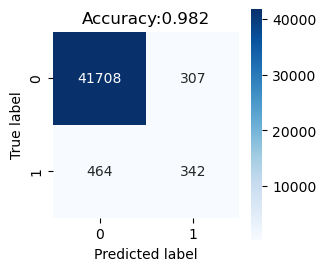

[0.98472179 0.98539279 0.98539279 0.98430887 0.98405079]

98.48 accuracy with a standard deviation of 0.05 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.53      0.42      0.47       806

    accuracy                           0.98     42821
   macro avg       0.76      0.71      0.73     42821
weighted avg       0.98      0.98      0.98     42821



In [188]:
random_forest(X_data, y_data, X_test, y_test)

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


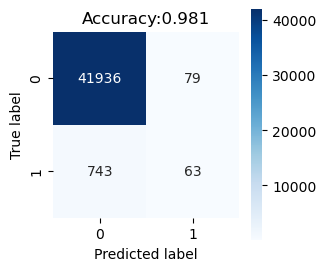

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.98255394 0.98203778 0.98147001 0.98193455 0.98229586]

98.21 accuracy with a standard deviation of 0.04 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     42015
           1       0.44      0.08      0.13       806

    accuracy                           0.98     42821
   macro avg       0.71      0.54      0.56     42821
weighted avg       0.97      0.98      0.97     42821



C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [189]:
log_regresion(X_data, y_data, X_test, y_test)

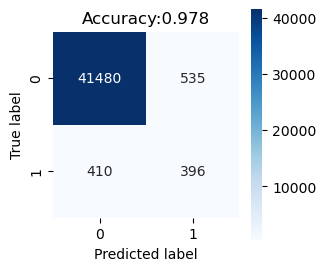

[0.98270878 0.98420564 0.98270878 0.98255394 0.98224424]

98.29 accuracy with a standard deviation of 0.07 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.43      0.49      0.46       806

    accuracy                           0.98     42821
   macro avg       0.71      0.74      0.72     42821
weighted avg       0.98      0.98      0.98     42821



In [190]:
decison_tree(X_data, y_data, X_test, y_test)

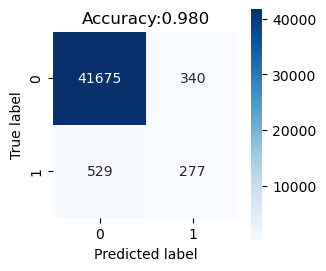

[0.98539279 0.98513472 0.98456695 0.98405079 0.9827604 ]

98.44 accuracy with a standard deviation of 0.09 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.45      0.34      0.39       806

    accuracy                           0.98     42821
   macro avg       0.72      0.67      0.69     42821
weighted avg       0.98      0.98      0.98     42821



In [191]:
KNN(X_data, y_data, X_test, y_test)

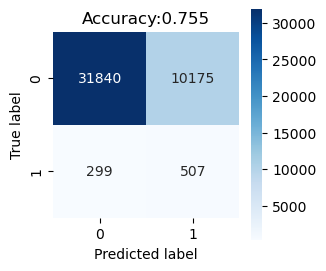

[0.71239806 0.78842779 0.76933003 0.7665944  0.76452978]

76.03 accuracy with a standard deviation of 2.54 

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     42015
           1       0.05      0.63      0.09       806

    accuracy                           0.76     42821
   macro avg       0.52      0.69      0.47     42821
weighted avg       0.97      0.76      0.84     42821



In [192]:
naive_bayes(X_data, y_data, X_test, y_test)

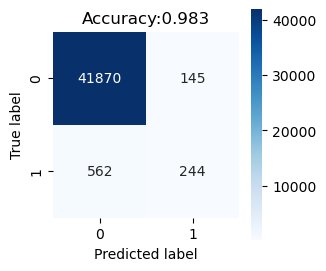

[0.98268528 0.98228494 0.98308562 0.98343592 0.98168443]

98.26 accuracy with a standard deviation of 0.06 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42015
           1       0.63      0.30      0.41       806

    accuracy                           0.98     42821
   macro avg       0.81      0.65      0.70     42821
weighted avg       0.98      0.98      0.98     42821



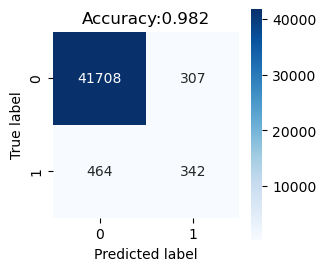

[0.98472179 0.98539279 0.98539279 0.98430887 0.98405079]

98.48 accuracy with a standard deviation of 0.05 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42015
           1       0.53      0.42      0.47       806

    accuracy                           0.98     42821
   macro avg       0.76      0.71      0.73     42821
weighted avg       0.98      0.98      0.98     42821



In [193]:
random_forest(X_train, y_train, X_test, y_test)
random_forest(X_data, y_data, X_test, y_test)

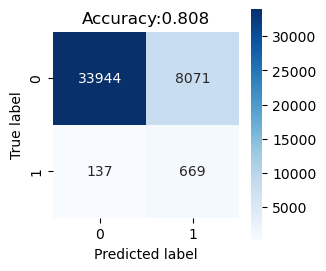

[0.80913097 0.80897725 0.81691007 0.8125032  0.80855752]

81.12 accuracy with a standard deviation of 0.32 

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     42015
           1       0.08      0.83      0.14       806

    accuracy                           0.81     42821
   macro avg       0.54      0.82      0.52     42821
weighted avg       0.98      0.81      0.88     42821



In [221]:
svm(X_allKNN, y_allKNN, X_test, y_test)

def log_regresion(xtrain, ytrain, xtest, ytest):
  clf = LogisticRegression(random_state=0)
  clf_model = clf.fit(xtrain, ytrain)
    
def decison_tree(xtrain, ytrain, xtest, ytest):
  clf = DecisionTreeClassifier(random_state=42)
  clf_model = clf.fit(xtrain, ytrain)
  
def KNN(xtrain, ytrain, xtest, ytest):
  clf = KNeighborsClassifier(n_neighbors=3)
  clf_model = clf.fit(xtrain, ytrain)
  
def naive_bayes(xtrain, ytrain, xtest, ytest):
  clf = GaussianNB()
  clf_model = clf.fit(xtrain, ytrain)
  
def svm(xtrain, ytrain, xtest, ytest):
  clf = SVC(gamma='scale', class_weight='balanced')
  clf_model = clf.fit(xtrain, ytrain)


In [217]:
def resultados_SVM_values(xtrain, ytrain, xtest, ytest,algoritmo):
  clf = SVC(gamma='scale', class_weight='balanced')
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)
    
  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  return df_X

#############################################################################

def resultados_log_regresion_values(xtrain, ytrain, xtest, ytest,algoritmo):
  clf = LogisticRegression(random_state=0)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)
    
  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  return df_X

#############################################################################

def resultados_decison_tree_values(xtrain, ytrain, xtest, ytest,algoritmo):
  clf = DecisionTreeClassifier(random_state=42)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)
    
  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  return df_X

#############################################################################

def resultados_KNN_values(xtrain, ytrain, xtest, ytest,algoritmo):
  clf = KNeighborsClassifier(n_neighbors=3)
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)
    
  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  return df_X

#############################################################################

def resultados_naive_bayes_values(xtrain, ytrain, xtest, ytest,algoritmo):
  clf = GaussianNB()
  clf_model = clf.fit(xtrain, ytrain)
  
  pred_test = clf_model.predict(xtest)
    
  f1score_test = round(f1_score(ytest, pred_test),2)
  recall_test = round(recall_score(ytest, pred_test),2)
  accuracy_test = round(accuracy_score(ytest, pred_test),2)
  precision_test = round(precision_score(ytest, pred_test),2)
    
  df_X = pd.DataFrame({'algoritmo':  [str(algoritmo)]
                      ,'accuracy': [accuracy_test]
                      ,'precision': [precision_test]
                      ,'recall': [recall_test] 
                      ,'f1-score': [f1score_test]
                      })
  return df_X

In [218]:
df_a_01 = resultados_random_values(X_data, y_data, X_test, y_test, "random_forest")
df_a_02 = resultados_log_regresion_values(X_data, y_data, X_test, y_test, "regresion_logistica")
df_a_03 = resultados_decison_tree_values(X_data, y_data, X_test, y_test, "decision_tree")
df_a_04 = resultados_KNN_values(X_data, y_data, X_test, y_test, "KNN")
df_a_05 = resultados_naive_bayes_values(X_data, y_data, X_test, y_test, "naive_bayes")
df_a_06 = resultados_SVM_values(X_data, y_data, X_test, y_test, "SVC")

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [220]:
display(df_a_06)

,algoritmo,accuracy,precision,recall,f1-score
0,SVC,0.8,0.07,0.82,0.14


In [219]:
df_resultados_final = df_a_01.append(df_a_02) \
                             .append(df_a_03) \
                             .append(df_a_04) \
                             .append(df_a_05) \
                             .append(df_a_06)

display(df_resultados_final.sort_values(by="f1-score", ascending = False).set_index('algoritmo'))

C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\2262453565.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados_final = df_a_01.append(df_a_02) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\2262453565.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_a_03) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\2262453565.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_a_04) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\2262453565.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df_a_05) \
C:\Users\mirei\AppData\Local\Temp\ipykernel_19288\2262453565.py:5: FutureWarning: The f

,accuracy,precision,recall,f1-score
algoritmo,,,,
random_forest,0.98,0.53,0.42,0.47
decision_tree,0.98,0.43,0.49,0.46
KNN,0.98,0.45,0.34,0.39
SVC,0.80,0.07,0.82,0.14
regresion_logistica,0.98,0.44,0.08,0.13
naive_bayes,0.76,0.05,0.63,0.09


# variables

Random forest

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [210]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest =  RandomForestClassifier(random_state=0).fit(X_data, y_data)

results_featres = pd.DataFrame({
    "feature name": X_train.columns,
    "importance": forest.feature_importances_
})

f1 = results_featres.sort_values(by="importance", ascending = False)

f1['importance'] = round(f1['importance']*100,3)

f1.head(5)

,feature name,importance
18,media_sesiones_dia,35.584
14,total_productos,25.910
19,dias_entre_sesiones,19.344
17,dias_sesiones,3.527
15,perfil_promocional,3.279


In [211]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
dtree =  DecisionTreeClassifier(random_state=42).fit(X_data, y_data)

results_featres = pd.DataFrame({
    "feature name": X_train.columns,
    "importance": dtree.feature_importances_
})

f1 = results_featres.sort_values(by="importance", ascending = False)

f1['importance'] = round(f1['importance']*100,3)

f1.head(5)

,feature name,importance
14,total_productos,29.403
19,dias_entre_sesiones,22.615
18,media_sesiones_dia,21.726
15,perfil_promocional,4.503
0,PF,3.100
